# Forecasting de Ventas - Desarrollo
### *Javier Ramírez*
---

## Índice

1. Importaciones
2. Extracción de datos
3. Regularización temporal
4. EDA (Análisis Exploratorio de Datos)
5. Limpieza de datos
6. Creación de variables
7. Transformación de datos
8. Preselección de variables

---

## 1. Importaciones

In [1]:
import warnings
# Ignorar todas las advertencias
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta, datetime
import pickle
from janitor import clean_names

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import mutual_info_regression

%matplotlib inline
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', None)

In [2]:
rc = {
    "axes.facecolor": "#F8F8F8",
    "figure.facecolor": "#F8F8F8",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7" + "30",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

# Configuración del estilo de seaborn con el diccionario rc
sns.set(rc=rc)

# Definición de colores
color = sns.color_palette('Purples')[3]
paleta = sns.color_palette('seismic')[0:5]

# Configuración de espaciado vertical y horizontal entre subgráficos
plt.rcParams['figure.subplot.hspace'] = 0.33
plt.rcParams['figure.subplot.wspace'] = 0.33

---

## 2. Extracción de Datos

### 2.1. Extraer todos los datasets

In [3]:
ruta = '../Datos/Originales/'

In [4]:
train = pd.read_csv(ruta + 'train.csv')
print('Rango de Fechas: ', train.date.min(), '-', train.date.max())
train.head()

Rango de Fechas:  2013-01-01 - 2017-08-15


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0
1,1,2013-01-01,1,BABY CARE,0.00,0
2,2,2013-01-01,1,BEAUTY,0.00,0
3,3,2013-01-01,1,BEVERAGES,0.00,0
4,4,2013-01-01,1,BOOKS,0.00,0


In [5]:
stores = pd.read_csv(ruta + 'stores.csv')
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [6]:
transactions = pd.read_csv(ruta + 'transactions.csv')
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [7]:
oil = pd.read_csv(ruta + 'oil.csv')
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [8]:
holidays = pd.read_csv(ruta + 'holidays_events.csv')
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [9]:
test = pd.read_csv(ruta + 'test.csv')
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


### 2.2 Unificar los datos

In [10]:
df = pd.concat([train, test], axis = 0)
df = df.merge(stores, how = 'left', on = 'store_nbr')
df = df.merge(transactions, how = 'left', on = ['date', 'store_nbr'])
df = df.merge(oil, how = 'left', on = 'date')
df = df.merge(holidays, how = 'left', on = 'date')
print('Estructura del dataset: ', df.shape)
df.head()

Estructura del dataset:  (3082860, 17)


,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,transactions,dcoilwtico,type_y,locale,locale_name,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0,Quito,Pichincha,D,13,NaN,NaN,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.00,0,Quito,Pichincha,D,13,NaN,NaN,Holiday,National,Ecuador,Primer dia del ano,False
2,2,2013-01-01,1,BEAUTY,0.00,0,Quito,Pichincha,D,13,NaN,NaN,Holiday,National,Ecuador,Primer dia del ano,False
3,3,2013-01-01,1,BEVERAGES,0.00,0,Quito,Pichincha,D,13,NaN,NaN,Holiday,National,Ecuador,Primer dia del ano,False
4,4,2013-01-01,1,BOOKS,0.00,0,Quito,Pichincha,D,13,NaN,NaN,Holiday,National,Ecuador,Primer dia del ano,False


---

## 3. Regularización Temporal

In [11]:
# Convertir la variable 'date' a formato fecha
df['date'] = pd.to_datetime(df['date'])

In [12]:
print('Número de familias de productos: ', train.family.nunique())
print('Número de tiendas: ', train.store_nbr.nunique())

Número de familias de productos:  33
Número de tiendas:  54


In [13]:
fecha_inicial = datetime(2013, 1, 1)
fecha_final = datetime(2017, 9, 1)

# Calcular la diferencia en días
diferencia = fecha_final - fecha_inicial

# Extraer el número de días de la diferencia
num_dias = diferencia.days

print("La diferencia en días es:", num_dias)

La diferencia en días es: 1704


In [14]:
print('Número de días en el dataset: ', df.date.nunique())

Número de días en el dataset:  1700


Faltan 4 días.

In [15]:
todos_los_dias = df.date.unique()

todos_los_dias_esperados = [fecha_inicial + timedelta(days=d) for d in range((fecha_final - fecha_inicial).days)]

# Encontrar los días que faltan
dias_faltantes = [dia for dia in todos_los_dias_esperados if dia not in todos_los_dias]

print("Días faltantes:", dias_faltantes)

Días faltantes: [datetime.datetime(2013, 12, 25, 0, 0), datetime.datetime(2014, 12, 25, 0, 0), datetime.datetime(2015, 12, 25, 0, 0), datetime.datetime(2016, 12, 25, 0, 0)]


Los 4 días que faltan son los días de Navidad, por lo que vamos a dejar el dataset igual, ya que ese día no se abren las tiendas.

In [16]:
print('Número de registros esperados: ', 1700 * 33 * 54)
print('Número de registros en el dataset: ', df.shape[0])

Número de registros esperados:  3029400
Número de registros en el dataset:  3082860


Vemos que hay más registros en el dataset de los que debería haber.

In [17]:
df.duplicated().sum()

0

In [18]:
df[['date', 'store_nbr', 'family']].duplicated().sum()

53460

In [19]:
fechas_duplicadas = df[df[['date', 'store_nbr', 'family']].duplicated()].date.unique()
fechas_duplicadas

<DatetimeArray>
['2013-05-12 00:00:00', '2013-06-25 00:00:00', '2013-07-03 00:00:00',
 '2013-12-22 00:00:00', '2014-06-25 00:00:00', '2014-07-03 00:00:00',
 '2014-12-22 00:00:00', '2014-12-26 00:00:00', '2015-06-25 00:00:00',
 '2015-07-03 00:00:00', '2015-12-22 00:00:00', '2016-04-21 00:00:00',
 '2016-05-01 00:00:00', '2016-05-07 00:00:00', '2016-05-08 00:00:00',
 '2016-05-12 00:00:00', '2016-06-25 00:00:00', '2016-07-03 00:00:00',
 '2016-07-24 00:00:00', '2016-11-12 00:00:00', '2016-12-22 00:00:00',
 '2017-04-14 00:00:00', '2017-06-25 00:00:00', '2017-07-03 00:00:00']
Length: 24, dtype: datetime64[ns]

In [20]:
df.loc[(df.date == '2017-07-03')].head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,transactions,dcoilwtico,type_y,locale,locale_name,description,transferred
2974158,2922480,2017-07-03,1,AUTOMOTIVE,0.00,0,Quito,Pichincha,D,13,1890.00,NaN,Holiday,Local,El Carmen,Cantonizacion de El Carmen,False
2974159,2922480,2017-07-03,1,AUTOMOTIVE,0.00,0,Quito,Pichincha,D,13,1890.00,NaN,Holiday,Local,Santo Domingo,Fundacion de Santo Domingo,False
2974160,2922481,2017-07-03,1,BABY CARE,0.00,0,Quito,Pichincha,D,13,1890.00,NaN,Holiday,Local,El Carmen,Cantonizacion de El Carmen,False
2974161,2922481,2017-07-03,1,BABY CARE,0.00,0,Quito,Pichincha,D,13,1890.00,NaN,Holiday,Local,Santo Domingo,Fundacion de Santo Domingo,False
2974162,2922482,2017-07-03,1,BEAUTY,5.00,1,Quito,Pichincha,D,13,1890.00,NaN,Holiday,Local,El Carmen,Cantonizacion de El Carmen,False


Podemos observar que al hacer la unión con la tabla de los festivos, se nos han duplicado aquellos registros que tenían varios festivos ese mismo día.

In [21]:
# Crear una variable que nos diga si ese día había dos festivos
df['two_holidays'] = df.date.apply(lambda x: 1 if x in fechas_duplicadas else 0)
# Eliminar los registros duplicados
df = df.drop_duplicates(subset = ['date', 'family', 'store_nbr'], keep = 'last')
df.shape

(3029400, 18)

Ahora ya podemos afirmar que el dataset está regularizado. Únicamente faltan los días de Navidad, ya que las tiendas no están abiertas y por lo tanto no habrá que predecir las ventas.

### 3.1. Separar entre train y test

In [22]:
# Función para reducir la memoria de uso
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

df = reduce_mem_usage(df)

Mem. usage decreased to 303.35 Mb (30.9% reduction)


In [23]:
# Cambiar el nombre de las variables
df = df.rename(columns = {'type_x':'tipo_store', 'type_y':'tipo_holiday'})

In [24]:
# Ordenar los registros
df = df.sort_values(by='id')
df = df.reset_index(drop=True)

# Separar entre train y test
train = df.iloc[:3000888].copy()
test = df.iloc[3000888:].copy()

# Guardar los datasets
df.to_csv('../Datos/df.csv', index=False)
train.to_csv('../Datos/train.csv', index=False)
test.to_csv('../Datos/test.csv', index=False)

---

## 4. EDA (Análisis Exploratiorio de Datos)

In [25]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 18 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            int32         
 1   date          datetime64[ns]
 2   store_nbr     int8          
 3   family        object        
 4   sales         float32       
 5   onpromotion   int16         
 6   city          object        
 7   state         object        
 8   tipo_store    object        
 9   cluster       int8          
 10  transactions  float16       
 11  dcoilwtico    float16       
 12  tipo_holiday  object        
 13  locale        object        
 14  locale_name   object        
 15  description   object        
 16  transferred   object        
 17  two_holidays  int8          
dtypes: datetime64[ns](1), float16(2), float32(1), int16(1), int32(1), int8(3), object(9)
memory usage: 277.6+ MB


In [26]:
# Definir los tipos de las variables
categoricas = ['store_nbr', 'family', 'city', 'state', 'tipo_store', 'cluster', 'tipo_holiday', 'locale', 'locale_name', 'description', 'transferred']
numericas = ['onpromotion', 'transactions', 'dcoilwtico']
target = 'sales'

Para este análisis voy a dividir los datos en diferentes palancas, sobre las que profundizaré y extraeré conclusiones. Estas palancas son:
- Ventas
- Fecha
- Tienda
- Familia de productos

Por último, realizaré un análisis del resto de variables, tanto numéricas como categóricas.

### 4.1. Análisis de las ventas

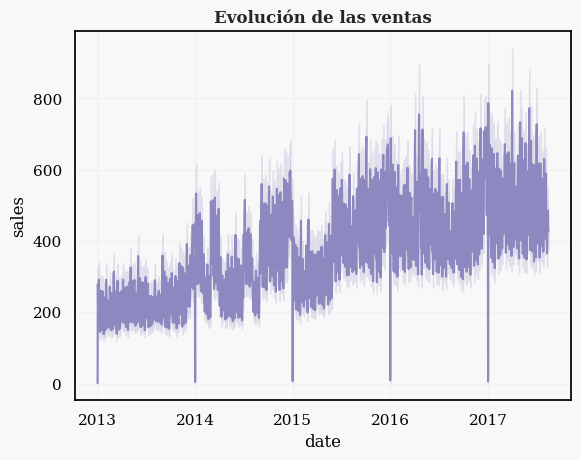

In [27]:
# Gráfico de lineas sobre la evolución de las ventas a lo largo del tiempo
a = sns.lineplot(data = train, x='date', y='sales', color = color)
a.set_title('Evolución de las ventas', fontsize=12, fontweight="bold");

La tendencia ha sido creciente todos estos años. Los puntos con 0 ventas han sido el primer día de cada año, ya que las tiendas no abrirían ese día.

### 4.2. Análisis temporal

In [28]:
# Añadir variables de la fecha al dataset
train_d = train.copy()
train_d['mes'] = train_d['date'].dt.month
train_d['dia'] = train_d['date'].dt.day
train_d['dia_año'] = train_d['date'].dt.day_of_year

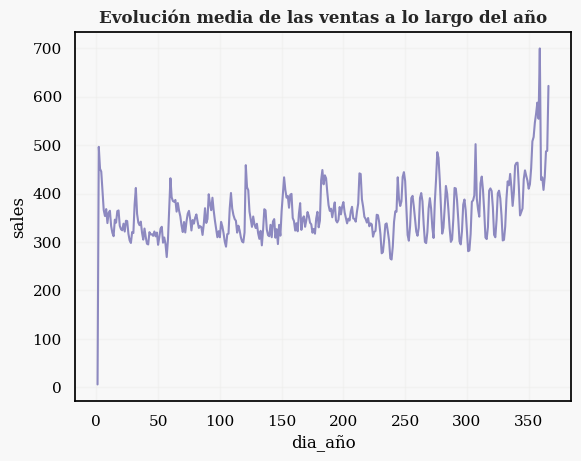

In [29]:
# Gráfico de lineas sobre la evolucion de las ventas a lo largo del año
a = train_d.groupby('dia_año')[['sales']].mean()
a = sns.lineplot(data = a.reset_index(), x='dia_año', y = 'sales', color = color)
a.set_title('Evolución media de las ventas a lo largo del año', fontsize=12, fontweight="bold");

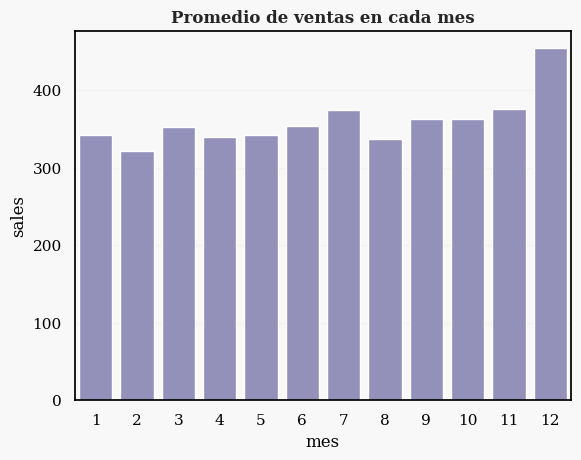

In [30]:
# Gráfico de barras sobre el promedio de ventas cada mes
a = train_d.groupby('mes')[['sales']].mean()
a = sns.barplot(data = a.reset_index(), x='mes', y = 'sales', color = color)
a.set_title('Promedio de ventas en cada mes', fontsize=12, fontweight="bold");

Las ventas permanecen estables durante la mayor parte del año, aunque experimentan un aumento en el último mes.

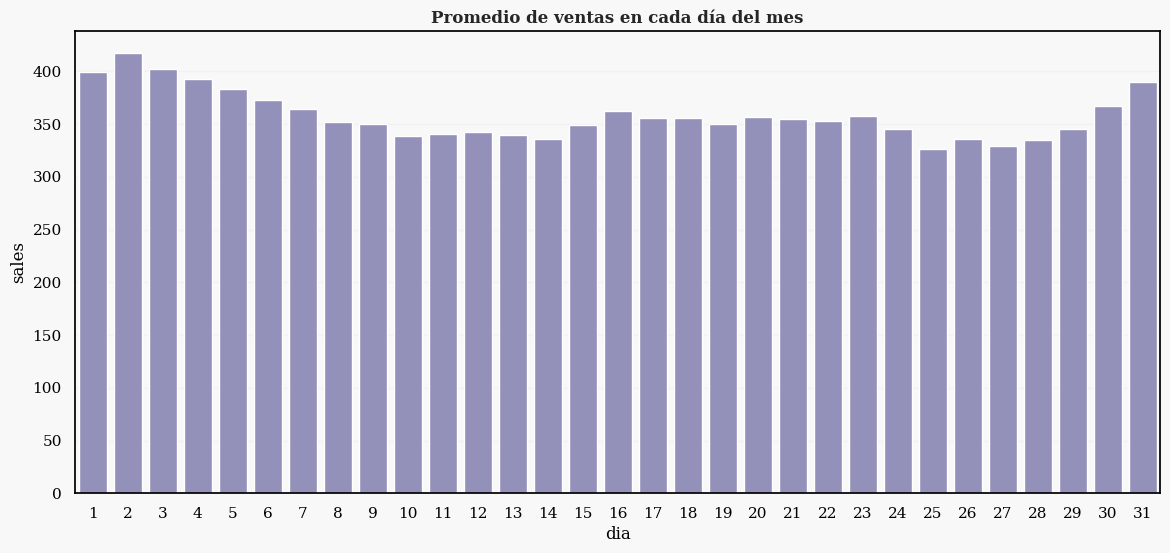

In [31]:
# Gráfico de barras sobre el promedio de ventas cada dia del mes
plt.figure(figsize=(14, 6))  
a = train_d.groupby('dia')[['sales']].mean()
a = sns.barplot(data=a.reset_index(), x='dia', y='sales', color=color)
a.set_title('Promedio de ventas en cada día del mes', fontsize=12, fontweight="bold");

Los primeros y los últimos días del mes suelen mostrar un ligero aumento en las ventas.

### 4.3. Análisis de las tiendas

In [32]:
# Análisis descriptivo
train.groupby('store_nbr')[['sales']].mean().describe()

,sales
count,54.00
mean,357.78
std,239.25
min,48.52
25%,199.69
50%,287.77
75%,446.80
max,1117.25


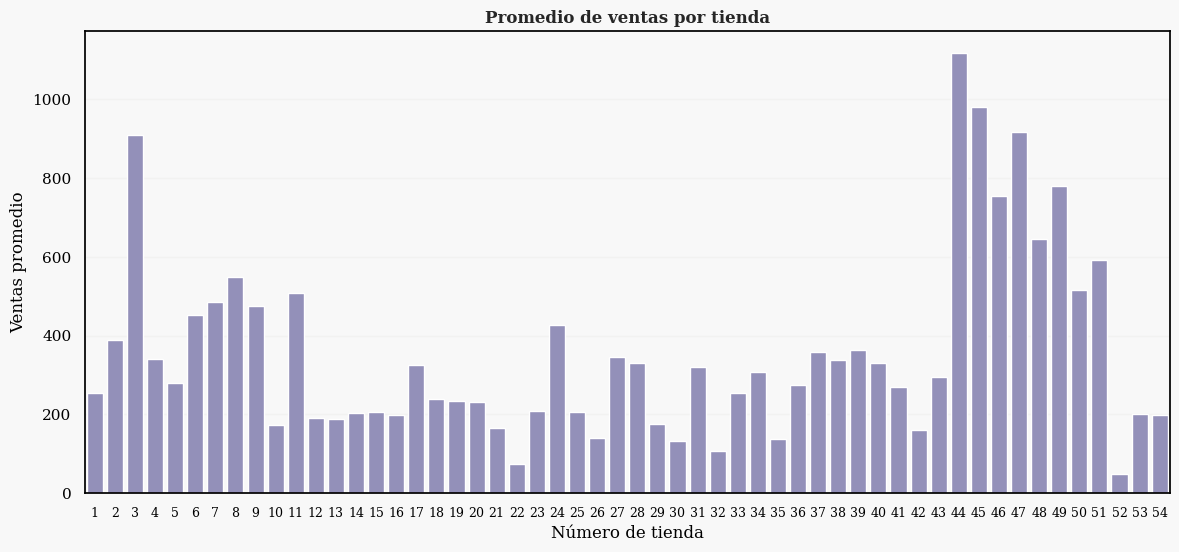

In [33]:
# Gráfico de barras sobre el promedio de ventas por tienda
plt.figure(figsize=(14, 6))
sns.barplot(data=train.groupby('store_nbr')[['sales']].mean().reset_index(), x='store_nbr', y='sales', color=color)
plt.title('Promedio de ventas por tienda', fontsize=12, fontweight='bold')
plt.xlabel('Número de tienda')
plt.ylabel('Ventas promedio')
plt.xticks(fontsize=9);

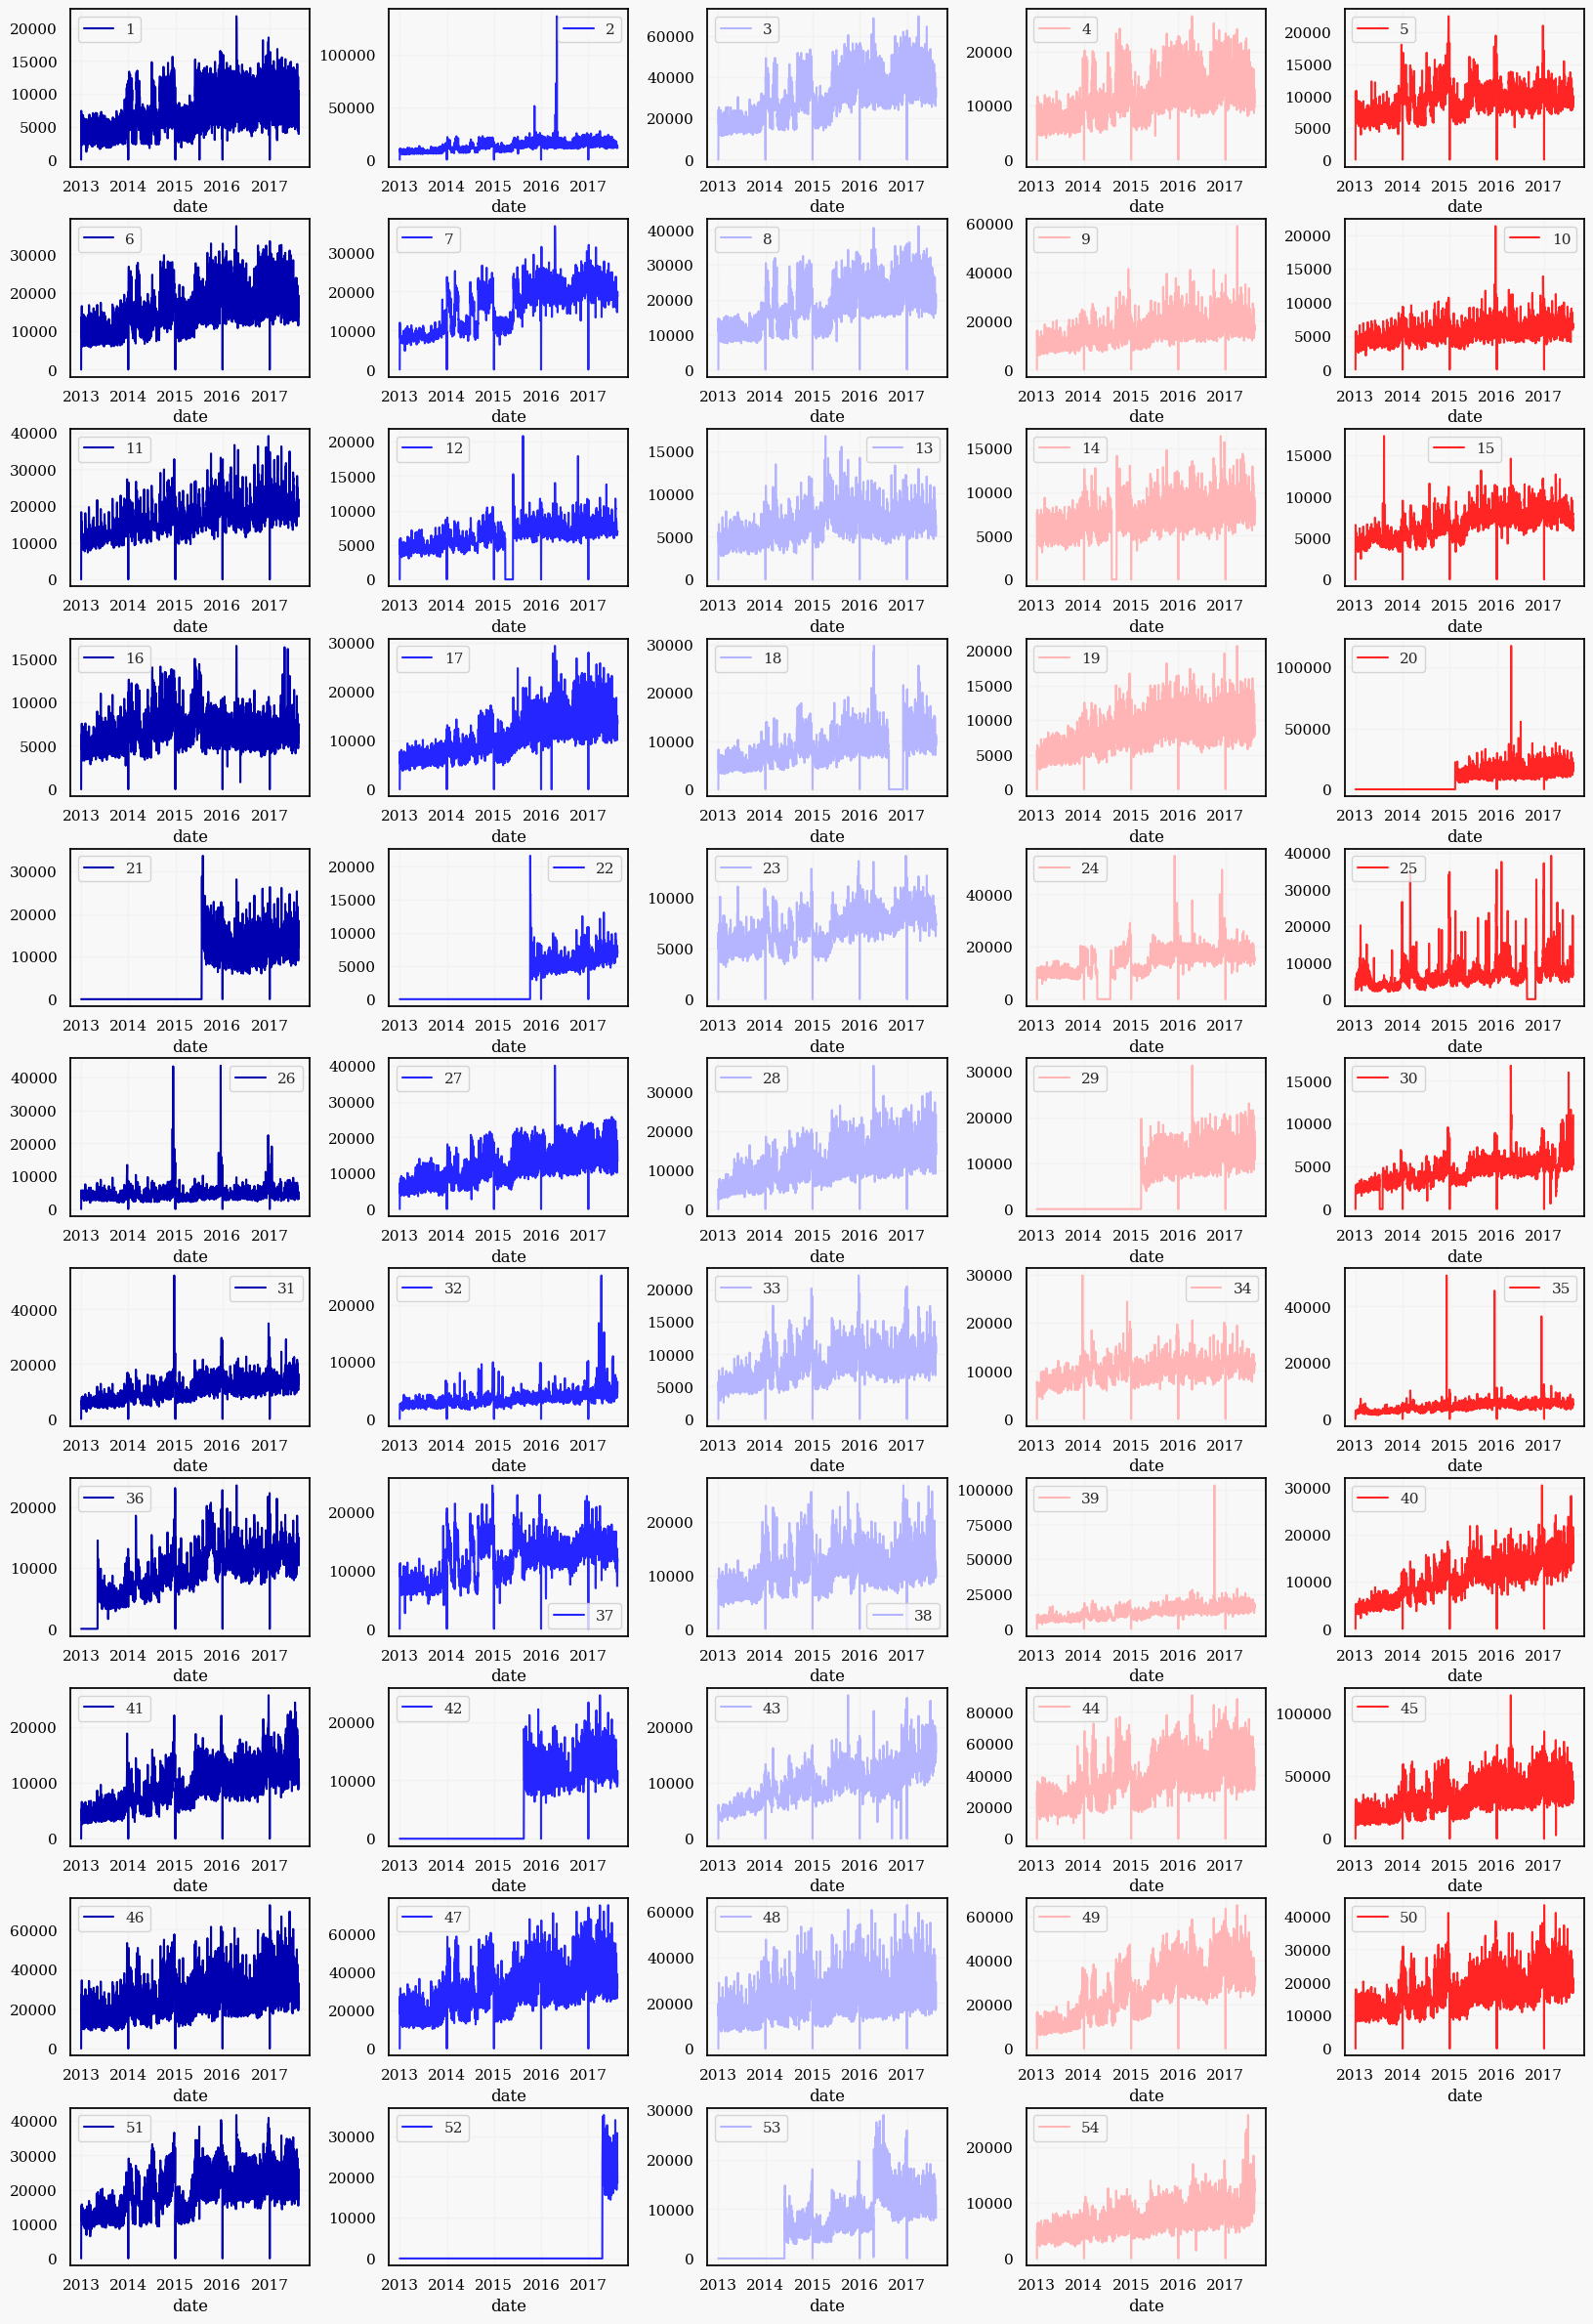

In [34]:
# Gráficos de lineas sobre la evolución de las ventas a lo largo del tiempo para cada tienda
train.groupby(['date','store_nbr']).sales.sum().unstack().plot(subplots = True,  layout = (11,5), sharex=False, figsize=(20,30), color = paleta);

Podemos observar que algunas tiendas no tienen ventas al principio, quizás porque aún no habían abierto. Por lo tanto, sería necesario crear una variable para resolver este problema.

### 4.4. Análisis de las familias de productos

In [35]:
# Análisis descriptivo
train.groupby('family')[['sales']].mean().describe()

,sales
count,33.00
mean,357.78
std,788.75
min,0.07
25%,6.04
50%,21.58
75%,270.43
max,3776.97


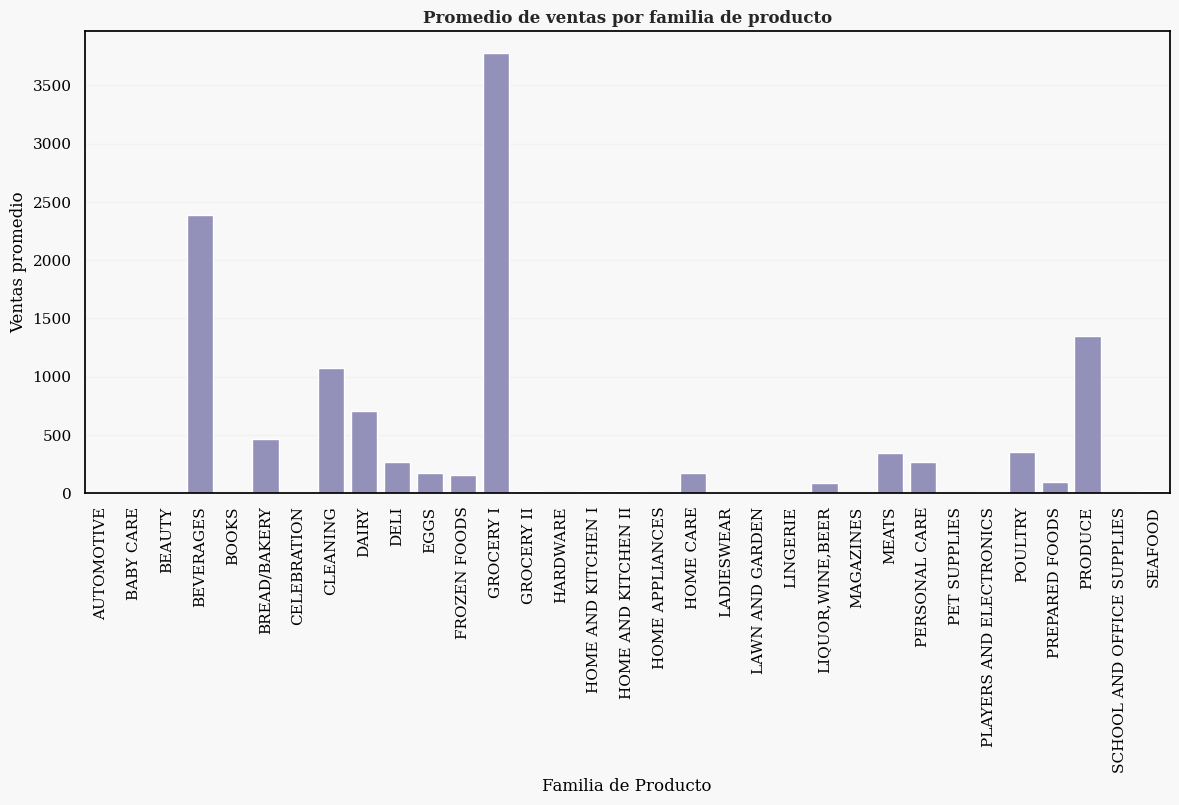

In [36]:
# Gráfico de barras sobre el promedio de ventas por familia de producto
plt.figure(figsize=(14, 6))
sns.barplot(data=train.groupby('family')[['sales']].mean().reset_index(), x='family', y='sales', color=color)
plt.title('Promedio de ventas por familia de producto', fontsize=12, fontweight='bold')
plt.xlabel('Familia de Producto')
plt.ylabel('Ventas promedio')
plt.xticks(rotation=90);

Existe una mayor variabilidad en el promedio de ventas por famila de producto que por tienda. Por esta razón, sería más conveniente dividir los modelos por familia de productos en lugar de por tienda. Esto significa crear un modelo para cada familia, dado que las ventas de cada producto varían considerablemente.

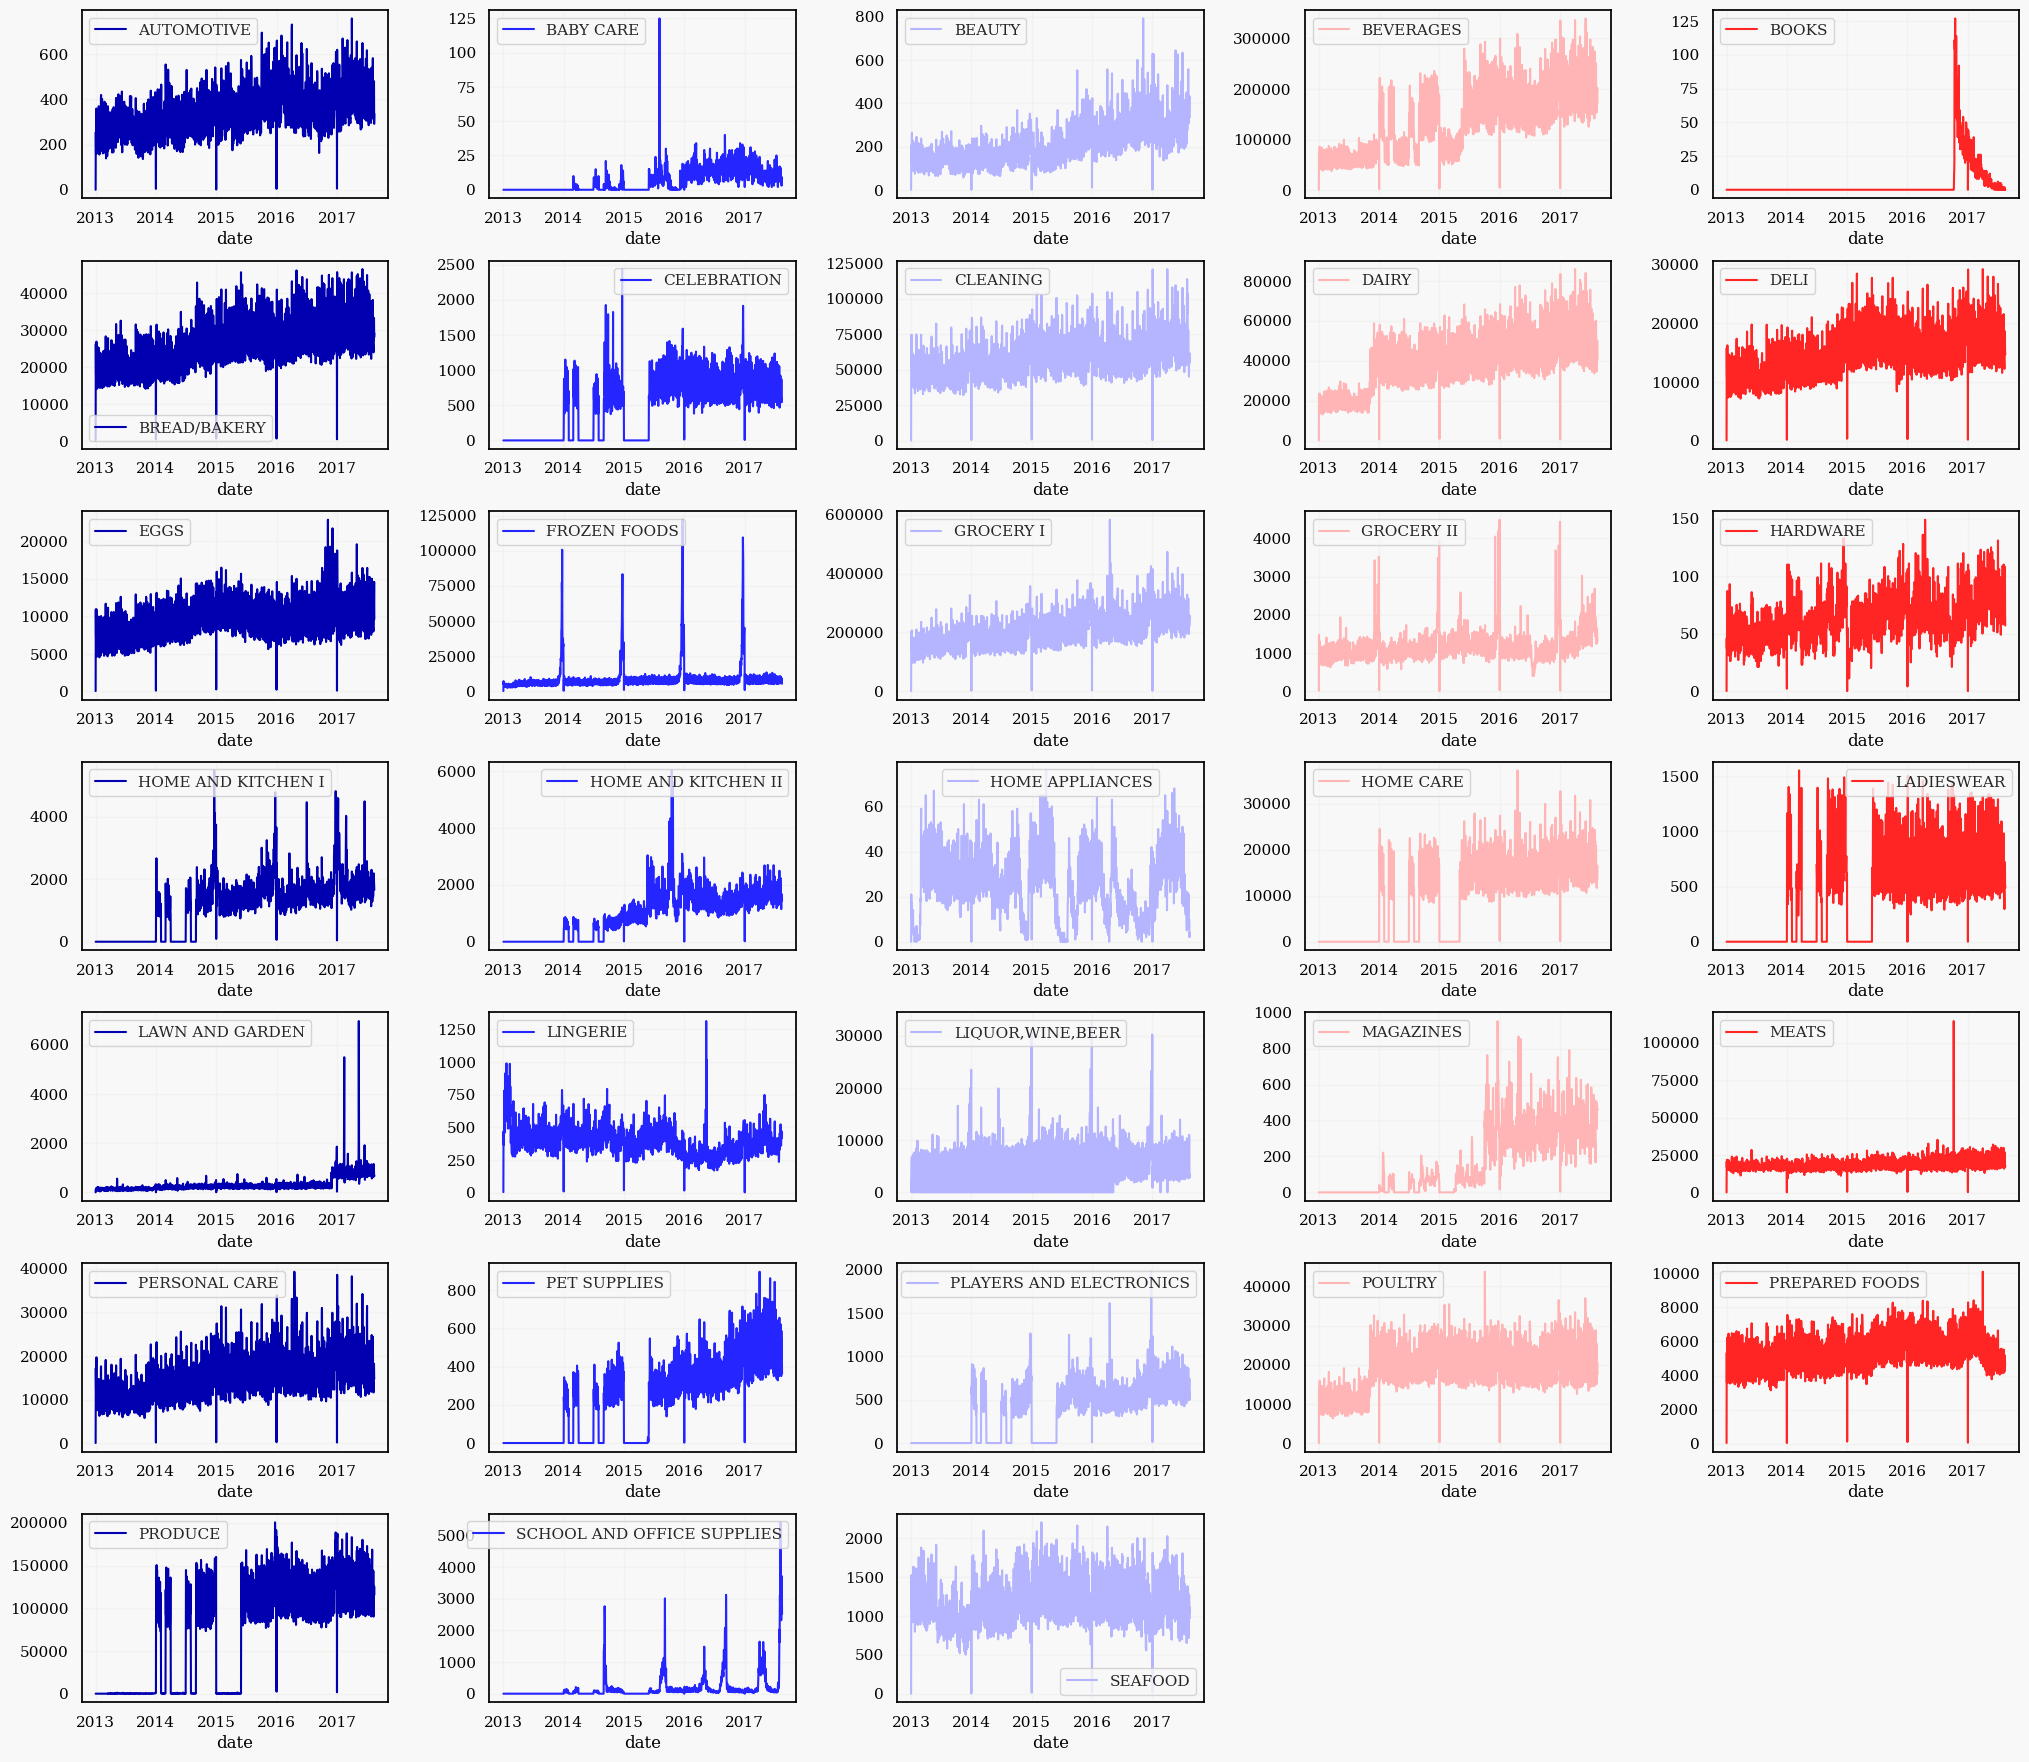

In [37]:
# Gráficos de lineas sobre la evolución de las ventas a lo largo del tiempo para cada familia de producto
train.groupby(['date','family']).sales.sum().unstack().plot(subplots = True,  layout = (11,5), sharex=False, figsize=(25,35), color = paleta);

Observamos que en muchas familias ocurre lo que se conoce como demanda intermitente, donde las ventas son nulas algunos días. Sin embargo, no podemos determinar si se debe a la falta de ventas o a la indisponibilidad del producto, ya sea porque aún no se había lanzado al mercado o debido a una rotura de stock.

Lo sorprendente es que esta situación se repite en las mismas fechas independientemente de la familia de productos. Durante todo el año 2013, por ejemplo, las ventas son nulas, lo que plantea la posibilidad de que el producto aún no estuviera disponible en el mercado. Posteriormente, desde todo el año 2014 hasta la mitad del 2015, hay períodos en los que las ventas son nulas en muchas familias.

Una posible solución sería crear una variable de rotura de stock que nos indique si en los días anteriores ha habido ventas nulas, lo que podría ayudarnos a entender mejor este patrón.

### 4.5. Análisis de las variables categóricas

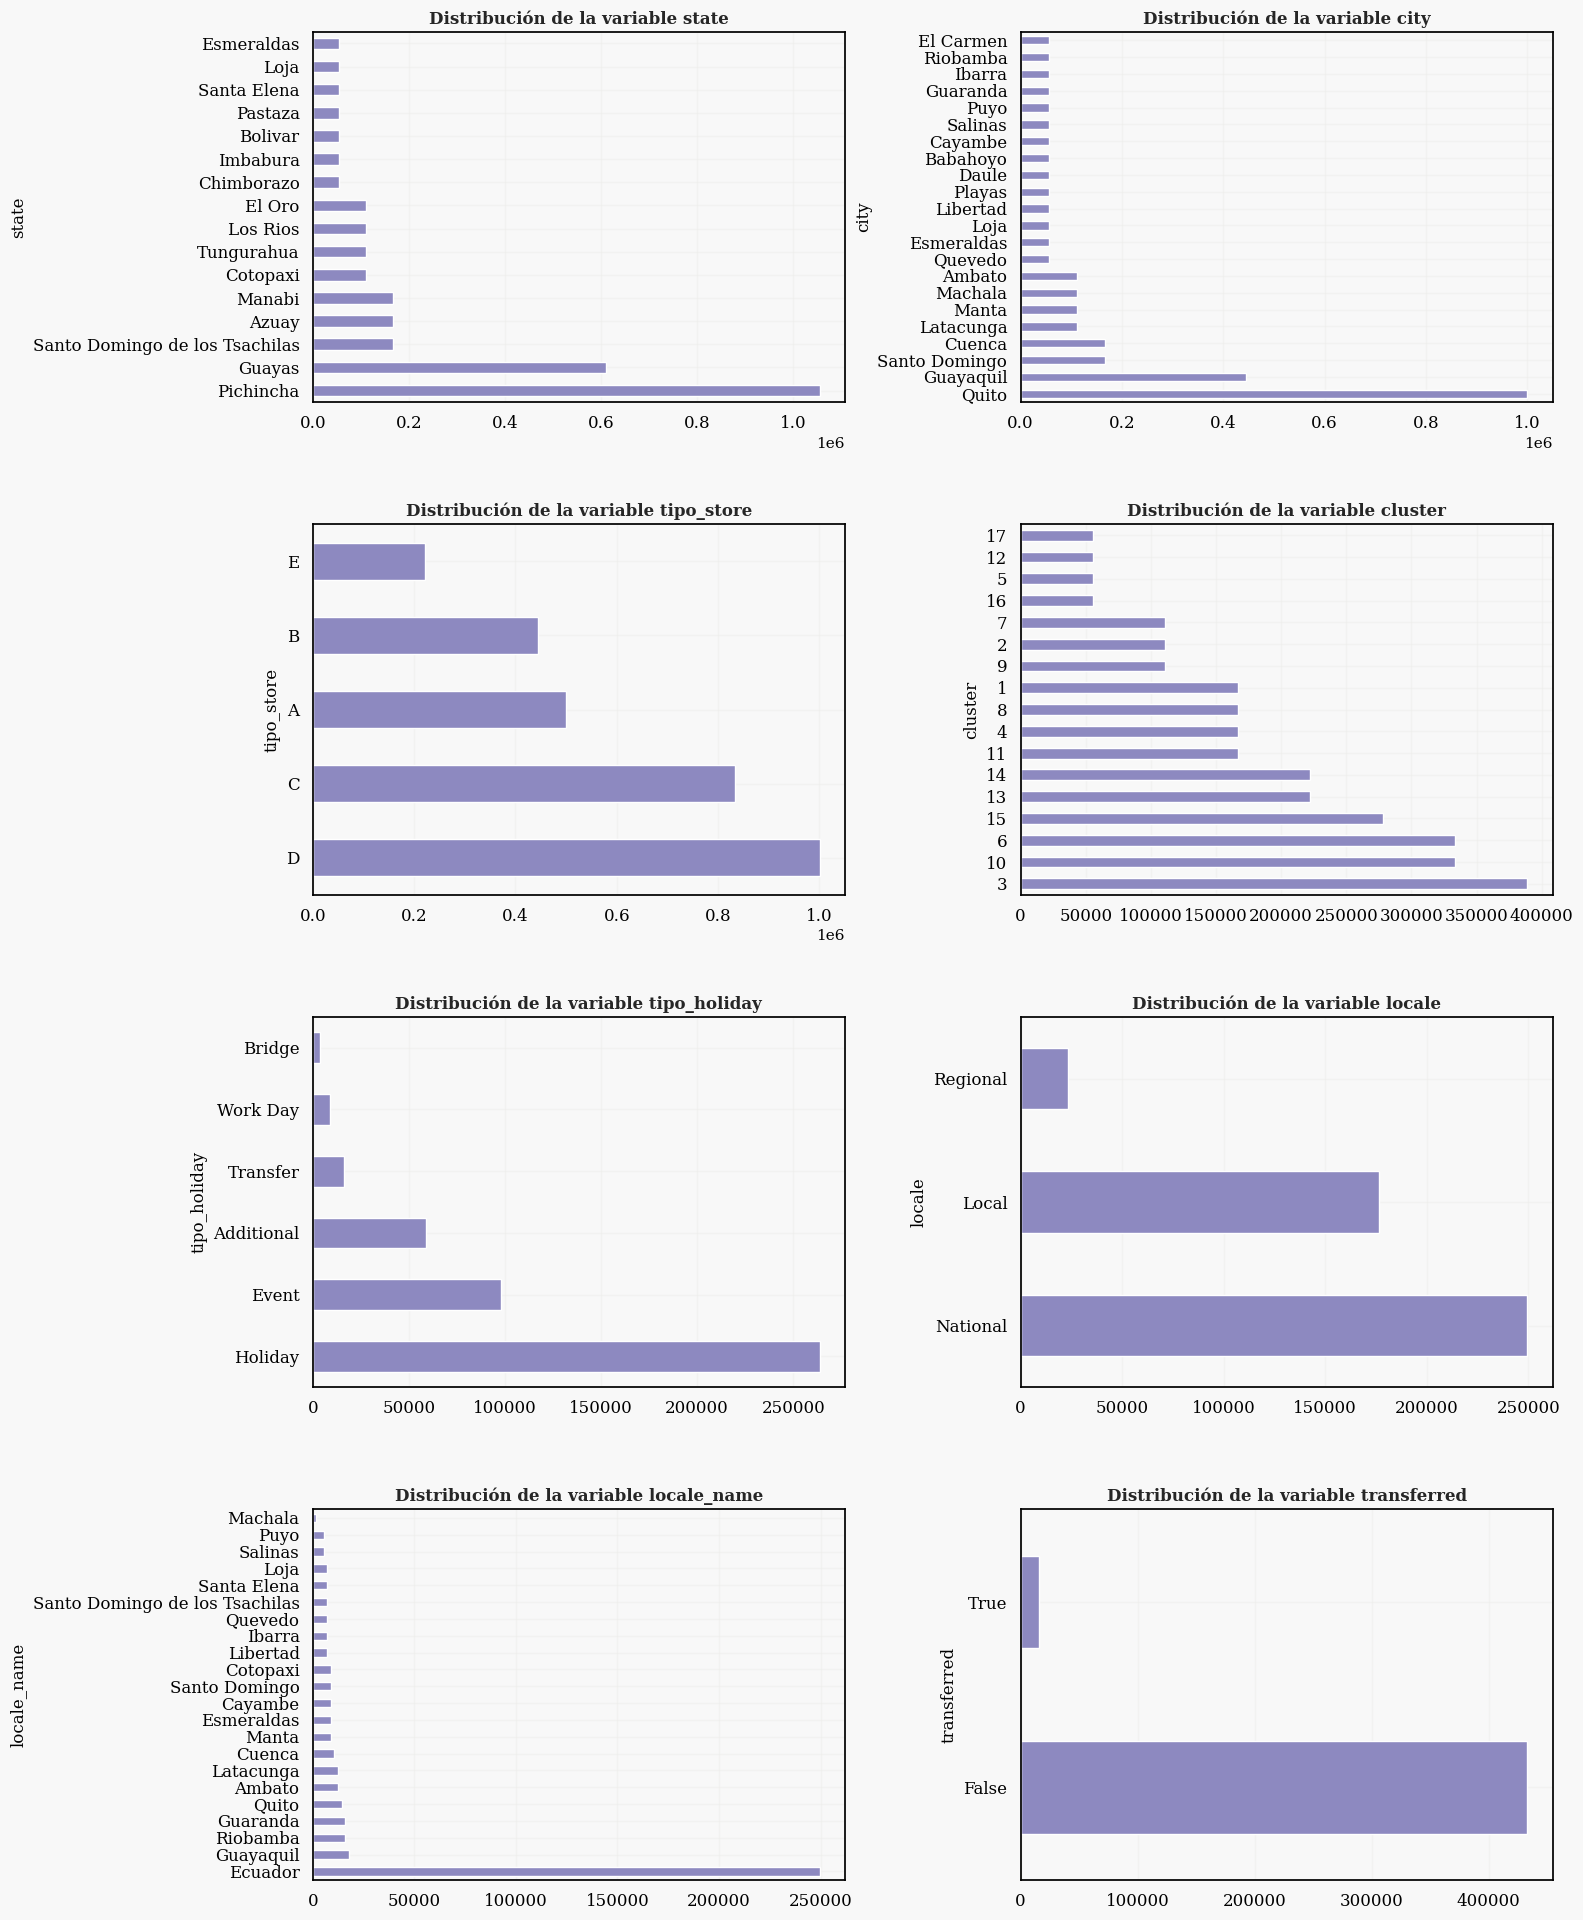

In [38]:
# Crear una función para generar gráficos que representen la distribución de cada variable categórica
def graficos_eda_categoricos(cat):
    
    #Calculamos el número de filas que necesitamos
    from math import ceil
    filas = ceil(cat.shape[1] / 2)

    #Definimos el gráfico
    f, ax = plt.subplots(nrows = filas, ncols = 2, figsize = (16, filas * 6))

    #Aplanamos para iterar por el gráfico como si fuera de 1 dimensión en lugar de 2
    ax = ax.flat 

    #Creamos el bucle que va añadiendo gráficos
    for n, variable in enumerate(cat):
        cat[variable].value_counts().plot.barh(ax = ax[n], color = color)
        ax[n].set_title('Distribución de la variable ' + variable, fontsize = 12, fontweight = "bold")
        ax[n].tick_params(labelsize = 12)

graficos_eda_categoricos(train[['state', 'city', 'tipo_store', 'cluster', 'tipo_holiday', 'locale', 'locale_name', 'transferred']])

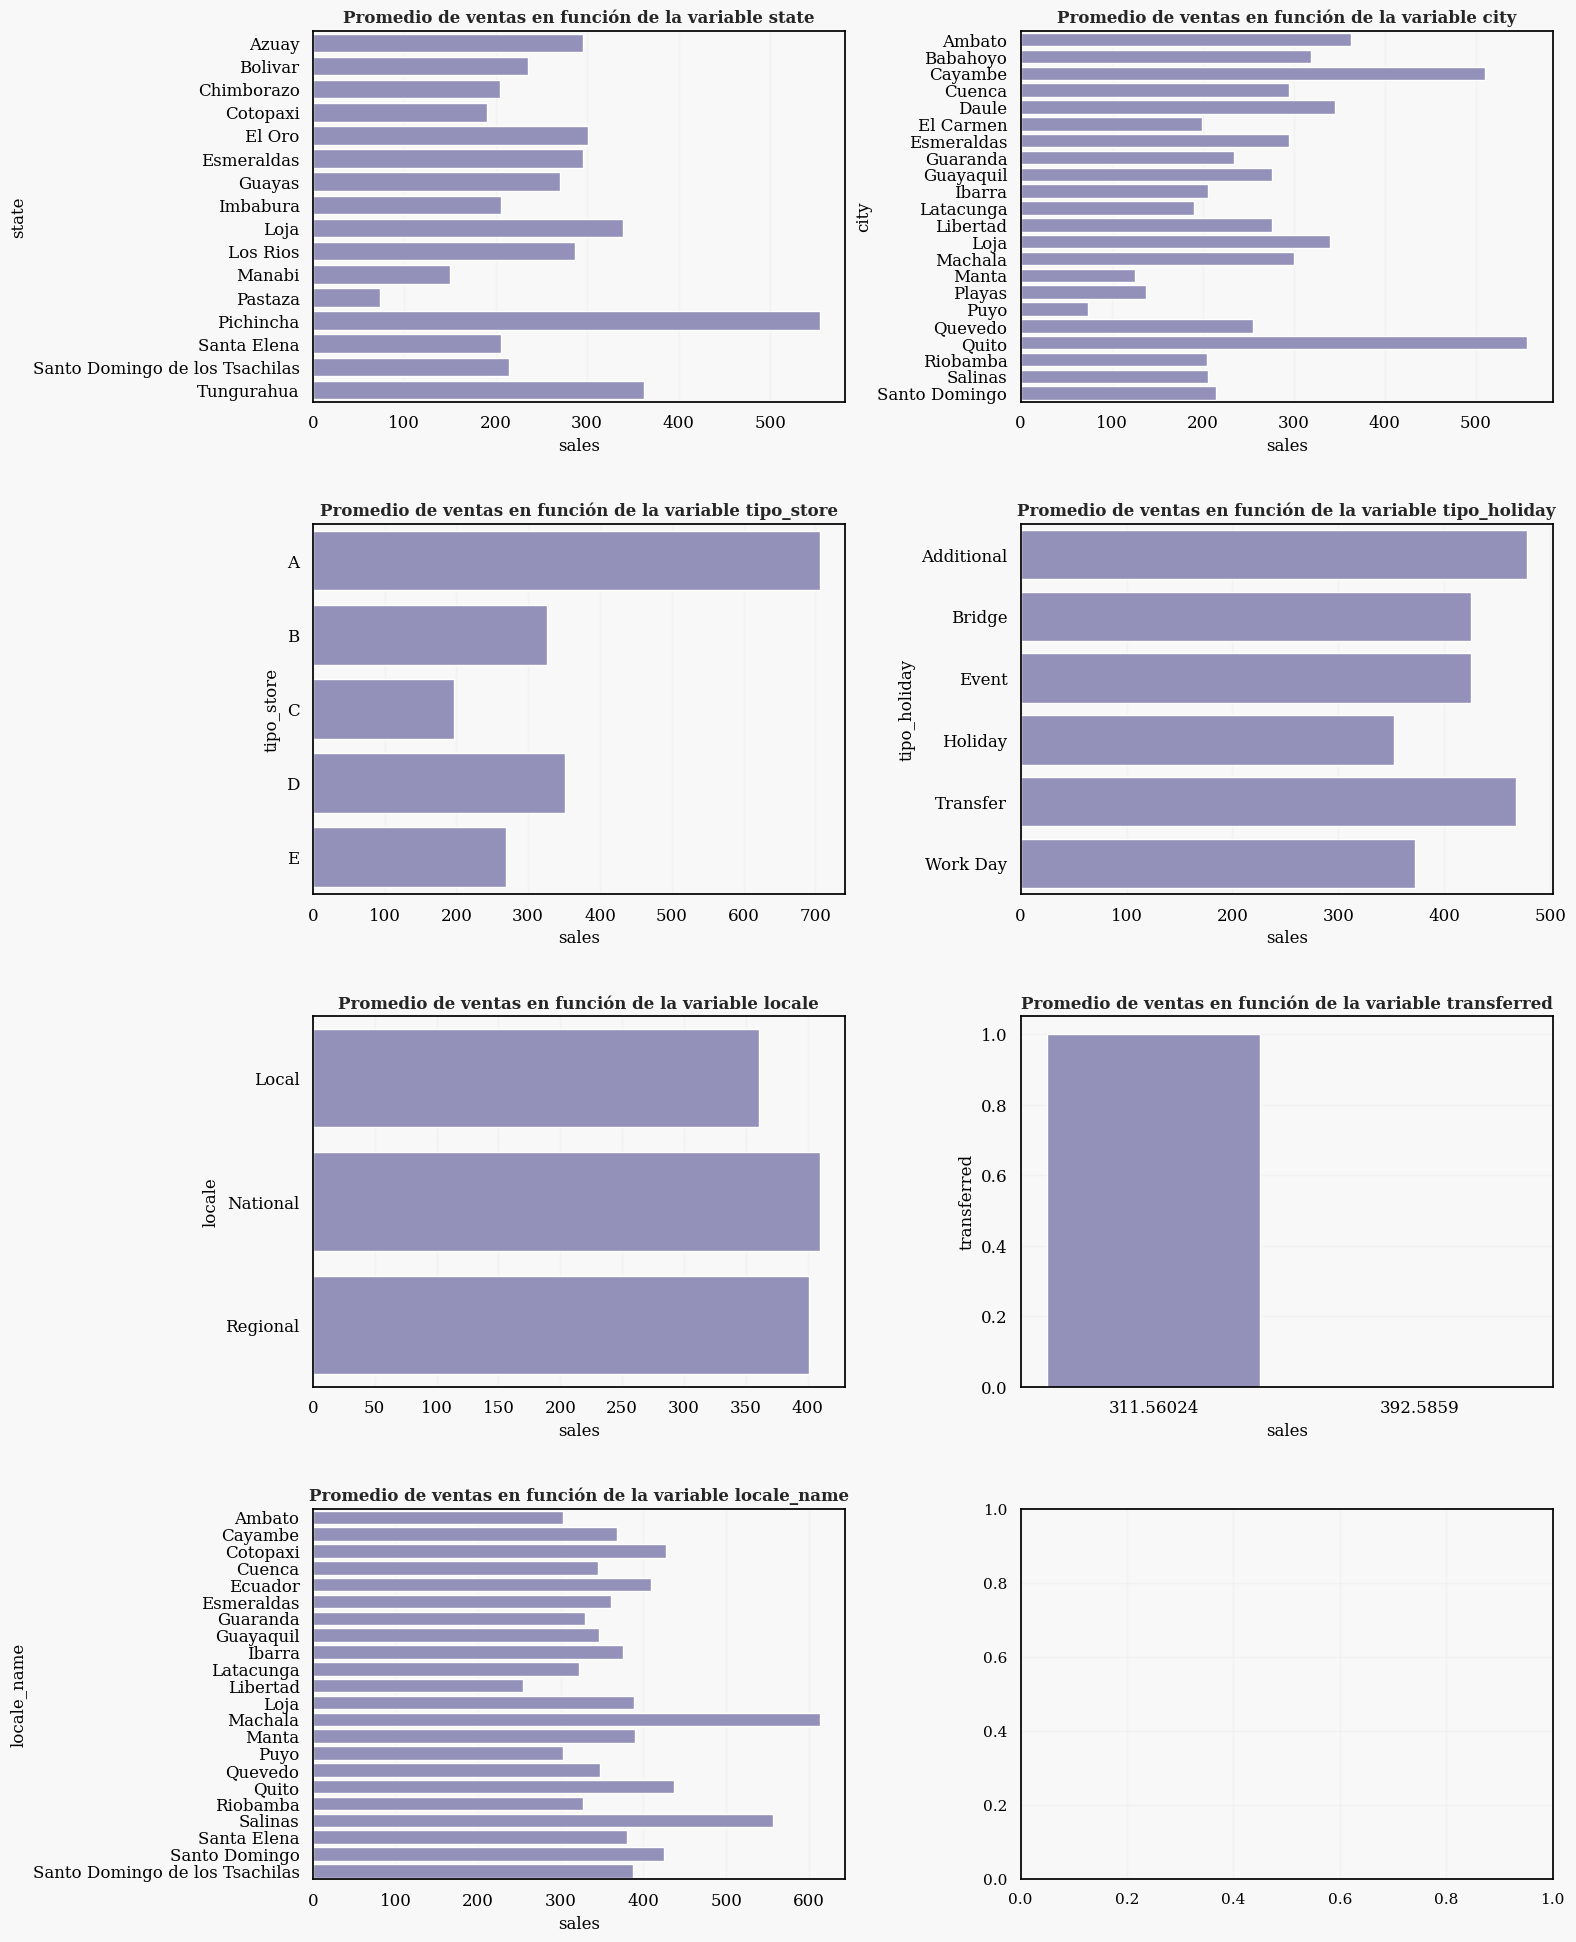

In [39]:
# Crear una función para generar gráficos que representen el promedio de ventas en función de cada variable categórica
def graficos_eda_categoricos(lista):
    
    # Calculamos el número de filas que necesitamos
    from math import ceil
    filas = ceil(train[lista].shape[1] / 2)

    # Definimos el gráfico
    f, ax = plt.subplots(nrows=filas, ncols=2, figsize=(16, filas * 6))

    # Aplanamos para iterar por el gráfico como si fuera de 1 dimensión en lugar de 2
    ax = ax.flat 

    # Creamos el bucle que va añadiendo gráficos
    for n, variable in enumerate(lista):
        data = train.groupby(variable)[['sales']].mean()
        sns.barplot(data=data.reset_index(), x='sales', y=variable, ci=False, ax = ax[n], color = color)
        ax[n].set_title('Promedio de ventas en función de la variable ' + variable, fontsize=12, fontweight="bold")
        ax[n].tick_params(labelsize=12)

graficos_eda_categoricos(['state', 'city', 'tipo_store', 'tipo_holiday', 'locale', 'transferred', 'locale_name'])

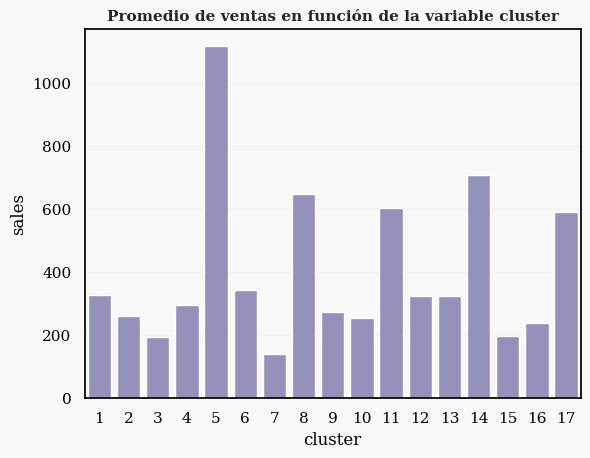

In [40]:
# Gráfico de barras sobre el promedio de ventas en función de la variable cluster
a = train.groupby('cluster')[['sales']].mean()
a = sns.barplot(data=a.reset_index(), y='sales', x='cluster', ci=False, color = color)
a.set_title('Promedio de ventas en función de la variable cluster', fontsize=11, fontweight="bold");

In [41]:
# Numero de tiendas por estado y ciudad
train.groupby(['state', 'city'])[['store_nbr']].nunique().reset_index()

,state,city,store_nbr
0,Azuay,Cuenca,3
1,Bolivar,Guaranda,1
2,Chimborazo,Riobamba,1
3,Cotopaxi,Latacunga,2
4,El Oro,Machala,2
5,Esmeraldas,Esmeraldas,1
6,Guayas,Daule,1
7,Guayas,Guayaquil,8
8,Guayas,Libertad,1
9,Guayas,Playas,1


Conclusiones:
- Pichincha es el estado con mayor número de tiendas y mayor promedio de ventas.
- La ciudad de Cayambe, aunque solo tiene una tienda, es la segunda ciudad que mas dinero de media genera al estar en el estado de Pichincha.
- A pesar de que Guayas es el segundo estado con más tiendas, ocupa el octavo lugar en cuanto al promedio de ventas.
- Las tiendas que pertenecen al cluster 5, en promedio, suelen generar mas del triple de ventas que la mayoria.
- Los días festivos en las ciudades de Machala y Salinas tienden a generar muchas más ventas que los días festivos en otras ciudades.
- Las tiendas tipo A suelen generar en promedio más del doble de ventas que el resto.


### 4.6. Análisis de las variables numéricas

In [42]:
# Análisis descriptivo
train[numericas].describe()

,onpromotion,transactions,dcoilwtico
count,3000888.00,2755104.00,2072466.00
mean,2.60,NaN,NaN
std,12.22,NaN,0.00
min,0.00,5.00,26.19
25%,0.00,1046.00,46.38
50%,0.00,1393.00,53.34
75%,0.00,2080.00,95.81
max,741.00,8360.00,110.62


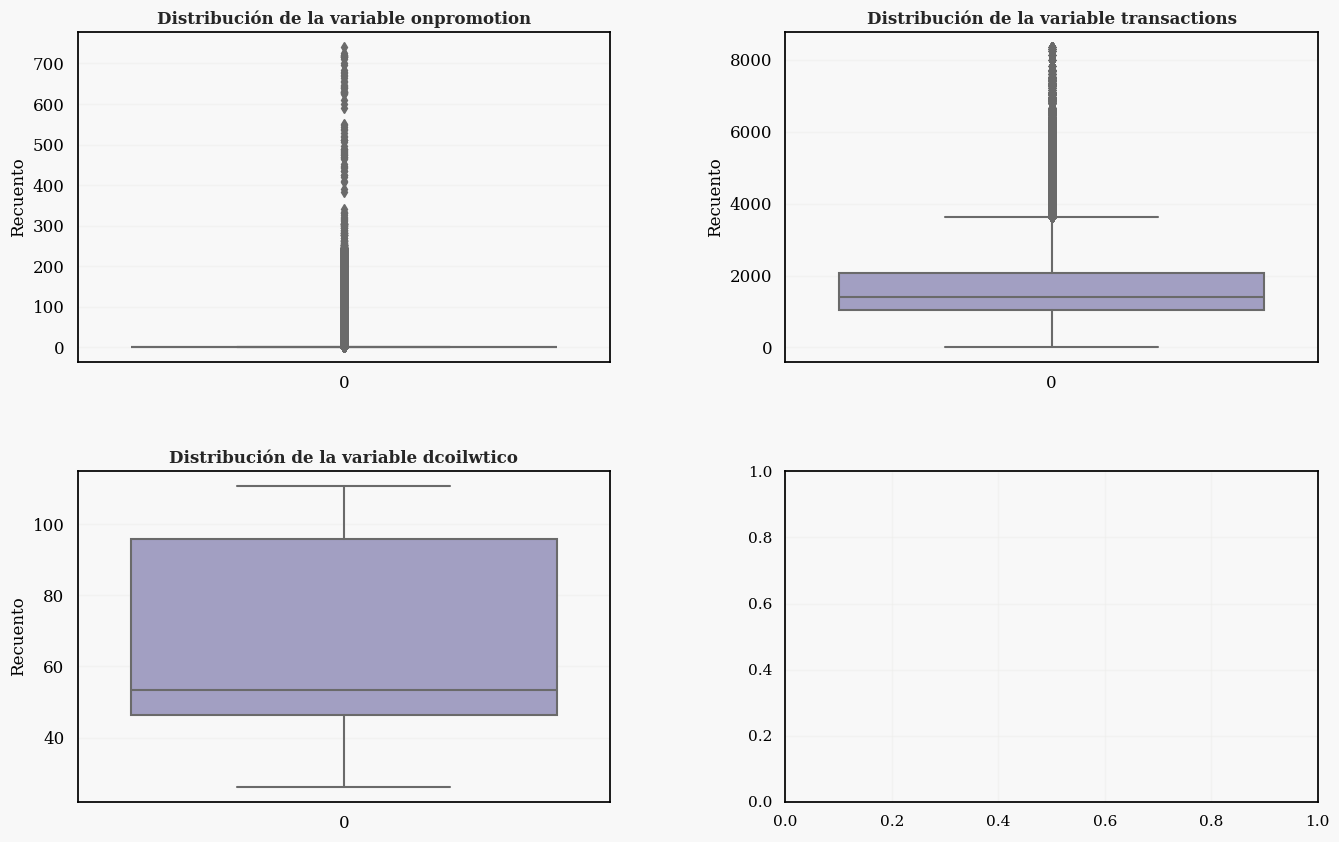

In [43]:
# Crear una función para generar gráficos boxplot que representen la distribución de cada variable numérica
f, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (16, 10))
ax = ax.flat
num_col = ['onpromotion', 'transactions', 'dcoilwtico']
for n, variable in enumerate(num_col):
    sns.boxplot(train[variable], ax=ax[n], palette = 'Purples');
    ax[n].set_title('Distribución de la variable ' + variable, fontsize=12, fontweight="bold")
    ax[n].set_ylabel('Recuento')
    ax[n].tick_params(labelsize = 12)

Como la mayoría de días no hay promociones, es normal que se generen tantos atípicos. Los atípicos de la variable transactions, se deben a las tiendas o familias de productos que generan una gran cantidad de ventas comparadas con el resto.

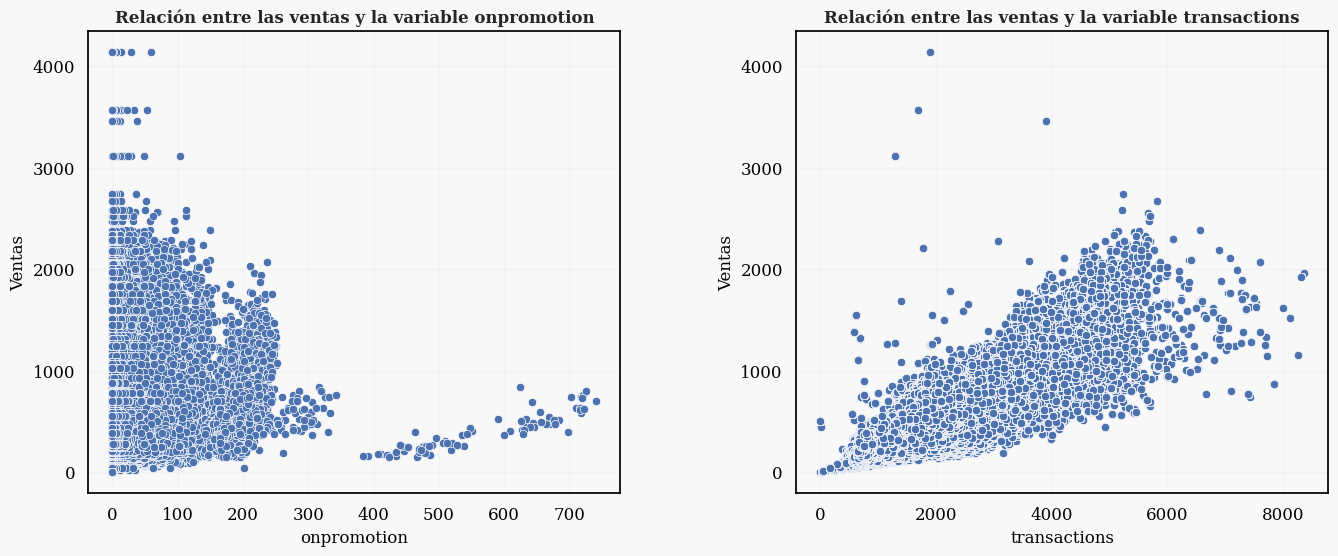

In [44]:
# Gráficos de dispersión entre las variables numéricas y sales
x = train.groupby(['store_nbr', 'date']).sales.mean().reset_index()
x = x.merge(train[['onpromotion', 'transactions', 'store_nbr', 'date']], how = 'left', on = ['store_nbr', 'date'])

f, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 6))
ax = ax.flat
num_col = ['onpromotion', 'transactions']
for n, variable in enumerate(num_col):
    sns.scatterplot(data = x, x=variable, y='sales', ax=ax[n], palette = 'Purples');
    ax[n].set_title('Relación entre las ventas y la variable ' + variable, fontsize=12, fontweight="bold")
    ax[n].set_ylabel('Ventas')
    ax[n].tick_params(labelsize = 12)

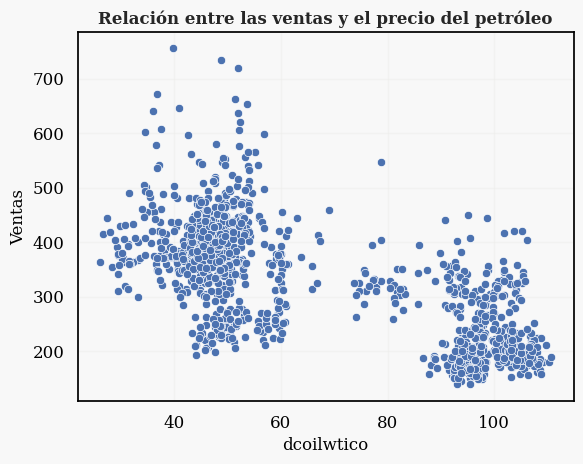

In [45]:
# Gráfico de dispersión entre las ventas y el precio del petróleo
x = train.groupby(['date'])[['sales', 'dcoilwtico']].mean()

a = sns.scatterplot(data = x, x='dcoilwtico', y='sales', palette = 'Purples');
a.set_title('Relación entre las ventas y el precio del petróleo', fontsize=12, fontweight="bold")
a.set_ylabel('Ventas')
a.tick_params(labelsize = 12)

La variable 'transactions' es la que mas correlación tiene con las ventas.

### Conclusiones Generales

- Se observa una tendencia creciente en las ventas a lo largo del tiempo.
- Las ventas tienden a mantenerse estables durante todo el año, con un aumento notable en diciembre.
- Se nota un ligero aumento en las ventas en los primeros y últimos días de cada mes.
- Algunas tiendas no estaban abiertas el primer día registrado (2013-01-01).
- Se identifica una demanda intermitente en algunas familias de productos.
- Existe una mayor variabilidad en el promedio de ventas por famila de producto que por tienda.

---

## 5. Limpieza de Datos

### 5.1. Tipos de datos

In [46]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 18 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            int32         
 1   date          datetime64[ns]
 2   store_nbr     int8          
 3   family        object        
 4   sales         float32       
 5   onpromotion   int16         
 6   city          object        
 7   state         object        
 8   tipo_store    object        
 9   cluster       int8          
 10  transactions  float16       
 11  dcoilwtico    float16       
 12  tipo_holiday  object        
 13  locale        object        
 14  locale_name   object        
 15  description   object        
 16  transferred   object        
 17  two_holidays  int8          
dtypes: datetime64[ns](1), float16(2), float32(1), int16(1), int32(1), int8(3), object(9)
memory usage: 277.6+ MB


Los tipos de datos están correctos, no hace falta cambiar nada.

### 5.2. Registros duplicados

In [47]:
print('Número de registros duplicados: ', train.duplicated().sum())

Número de registros duplicados:  0


No existen duplicados.

### 5.3. Valores nulos

In [48]:
train.isna().sum()

id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
city                  0
state                 0
tipo_store            0
cluster               0
transactions     245784
dcoilwtico       928422
tipo_holiday    2551824
locale          2551824
locale_name     2551824
description     2551824
transferred     2551824
two_holidays          0
dtype: int64

Solo hay nulos en las variables transactions y dcoilwtico, ya que los nulos de las demás variables significan que no habia día festivo.

Lo primero que haremos es corregir los valores nulos de las variables festivas, ya que entendemos que su ausencia indica la falta de festividad. Para esto, los imputaremos con el valor 'Sin festivo'.

In [49]:
var_fest = ['tipo_holiday', 'locale', 'locale_name', 'description', 'transferred']
train[var_fest] = train[var_fest].fillna('Sin festivo')

#### 5.3.1. Transactions

La variable transactions indica el número de compras que se ha hecho en un día en una tienda en específica, por lo que, en principio, debería estar relacionada con la variable 'sales'.

In [50]:
pc = train.transactions.isna().sum() / train.shape[0]
print('Porcentaje de nulos en la variable "transactions": ', round(pc, 2), '%')

Porcentaje de nulos en la variable "transactions":  0.08 %


In [51]:
train[train.transactions.isna()].sales.describe()

count   245784.00
mean         9.69
std        234.48
min          0.00
25%          0.00
50%          0.00
75%          0.00
max      19988.63
Name: sales, dtype: float64

In [52]:
# Añadir una variable del acumulado de ventas en un día para cada tienda
sales_acum = train.groupby(['store_nbr', 'date'])[['sales']].sum().reset_index().rename(columns = {'sales':'sales_acum'})
train = train.merge(sales_acum, how='left', on = ['store_nbr', 'date'])
sales_acum

,store_nbr,date,sales_acum
0,1,2013-01-01,0.00
1,1,2013-01-02,7417.15
2,1,2013-01-03,5873.24
3,1,2013-01-04,5919.88
4,1,2013-01-05,6318.79
...,...,...,...
90931,54,2017-08-11,8513.83
90932,54,2017-08-12,9139.68
90933,54,2017-08-13,14246.83
90934,54,2017-08-14,11882.99


In [53]:
correlation = train['transactions'].corr(train['sales_acum'])
print("Correlación entre 'transactions' y 'sales_acum':", round(correlation, 2))

Correlación entre 'transactions' y 'sales_acum': 0.84


Como es lógico, la suma de las ventas de cada familia de productos en un día y una tienda específica ('sales_acum'), está muy correlacionada con el número de transacciones que tiene una tienda en un día ('transactions').

Los días en los que una tienda no ha registrado ventas indican que el número de transacciones también ha sido de 0.

In [54]:
# Asignarle un 0 a las transacciones para los dias en las que la tienda tiene 0 ventas
train.loc[(train['transactions'].isna()) & (train['sales_acum'] == 0), 'transactions'] = 0

In [55]:
train.transactions.isna().sum()

3894

Gracias a este proceso, hemos eliminado una gran cantidad de valores nulos. El resto de nulos los imputaremos utilizando la interpolación lineal.

In [56]:
x = train[['store_nbr', 'date', 'transactions']].drop_duplicates()
    
def interpolate_group(group):
    return group['transactions'].interpolate(method='linear')

# Aplicar la interpolación a cada grupo
interpolated_transactions = x.groupby('store_nbr').apply(interpolate_group)
result = interpolated_transactions.reset_index(level=0, drop=True)
x['transactions'] = result
# Incluir la nueva columna con todos los valores al dataset principal
train = train.drop(columns = 'transactions').merge(x, how = 'left', on = ['store_nbr', 'date'])

# Elimino la variable 'sales_acum' ya que en la siguiente fase la volveremos a crear
train = train.drop(columns = 'sales_acum')

print('Número de nulos después de la interpolación: ', train.transactions.isna().sum())

Número de nulos después de la interpolación:  0


#### 5.3.2. Dcoilwtico

In [57]:
pc = train.dcoilwtico.isna().sum() / train.shape[0]
print('Porcentaje de nulos en la variable "dcoilwtico": ', round(pc, 2), '%')

Porcentaje de nulos en la variable "dcoilwtico":  0.31 %


In [58]:
n = train[train.dcoilwtico.isna()].date.nunique()
print('Número de días con valor nulo: ', n)

Número de días con valor nulo:  521


In [59]:
# Agrupar los datos
oil = train.groupby('date')[['dcoilwtico']].mean()
# Interpolar el valor de 'dcoilwtico' utilizando el método de interpolación lineal para llenar los valores nulos.
oil = oil.interpolate(method='linear')
# Imputar el valor del primer día, el único de falta, por el valor del segundo día
oil = oil.fillna(93.14)
train = train.drop(columns = 'dcoilwtico')
# Incluir la nueva columna con todos los valores al dataset principal
train = train.merge(oil, how = 'left', on = 'date')
print('Número de nulos después de la interpolación: ', train.dcoilwtico.isna().sum())

Número de nulos después de la interpolación:  0


#### 5.3.3. Comprobación de nulos

In [60]:
print('Nulos después de la limpieza: ', train.isna().sum().sum())

Nulos después de la limpieza:  0


### 5.4. Gestión de valores atípicos

En el EDA observamos atípicos en las variables transactions y onpromotion

In [61]:
train.onpromotion.describe()

count   3000888.00
mean          2.60
std          12.22
min           0.00
25%           0.00
50%           0.00
75%           0.00
max         741.00
Name: onpromotion, dtype: float64

In [62]:
train.transactions.describe()

count   3000888.00
mean           NaN
std            NaN
min           0.00
25%         931.00
50%        1332.00
75%        1978.00
max        8360.00
Name: transactions, dtype: float64

In [63]:
num_desv_tip = 4

def atipicos_desv_tip(variable, num_desv_tip = 4):
    #sacamos los nulos por ahora
    variable = variable.dropna()
    #calculamos los límites
    media = np.mean(variable)
    sd = np.std(variable)
    umbral = sd * num_desv_tip
    lim_inf = media - umbral
    lim_sup = media + umbral
    #encontramos los índices de los que están fuera de los límites
    indices = [indice for indice,valor in variable.items() if valor < lim_inf or valor > lim_sup]
    return(indices)

def conteo_atipicos(df,variable, num_desv_tip = 4):
    atipicos = atipicos_desv_tip(df[variable], num_desv_tip)
    return(df.loc[atipicos,variable].value_counts())

var_atipicos_dt = ['onpromotion','transactions']

for variable in var_atipicos_dt:
    print('\n' + variable + ':\n')
    print(conteo_atipicos(train,variable,num_desv_tip))


onpromotion:

onpromotion
53     1360
52     1340
54     1195
55     1090
56     1045
       ... 
383       1
600       1
306       1
672       1
425       1
Name: count, Length: 310, dtype: int64

transactions:

Series([], Name: count, dtype: int64)


Dado que hay muchos atípicos, no voy a hacer nada con ellos.

---

## 6. Creación de Variables

### 6.1. Variables a partir de la fecha

In [64]:
# Creación de nuevas columnas 'month', 'day', 'year', 'weekday', 'day_of_year' y 'quarter' a partir de la columna 'date'
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day
train['year'] = train['date'].dt.year
train['weekday'] = train['date'].dt.weekday
train['day_of_year'] = train['date'].dt.dayofyear
train['quarter'] = train['date'].dt.quarter

# Definición de una función para asignar la estación del año en función del día del año
def estacion(x):
    spring = range(80, 172)
    summer = range(172, 264)
    fall = range(264, 355)
    
    if x in spring:
      return 1
    elif x in summer:
      return 2
    elif x in fall:
      return 3
    else:
      return 0

train['season'] = train['day_of_year'].apply(estacion)

### 6.2. Variables a partir de los días festivos

In [65]:
pd.DataFrame(train.description.value_counts()).head(20)

,count
description,
Sin festivo,2551824
Carnaval,17820
Fundacion de Cuenca,10692
Primer dia del ano,8910
Dia de la Madre,8910
Fundacion de Riobamba,8910
Primer Grito de Independencia,8910
Fundacion de Esmeraldas,8910
Fundacion de Guayaquil,8910


Vamos a crear variables para las festividades mas 'importantes'.

In [66]:
# Creación de columnas indicadoras de diferentes festividades a partir de la columna 'description'
train['holiday_navidad'] = train.description.apply(lambda x: 1 if 'navidad' in str(x).lower() else 0)
train['holiday_carnaval'] = train.description.apply(lambda x: 1 if 'carnaval' in str(x).lower() else 0)
train['holiday_dia_padre_madre'] = train.description.apply(lambda x: 1 if 'dia de la madre' in str(x).lower() or 'dia del padre' in str(x).lower() else 0)
train['holiday_cuenca'] = train.description.apply(lambda x: 1 if 'fundacion de cuenca' in str(x).lower() else 0)
train['holiday_viernes_santo'] = train.description.apply(lambda x: 1 if 'viernes santo' in str(x).lower() else 0)

# Creación de una columna que indica si es el primer día del año
train['holiday_primer_dia_ano'] = 0
train.loc[(train.date.dt.month == 1) & (train.date.dt.day == 1), 'holiday_primer_dia_ano'] = 1

In [67]:
# Crear una variable que nos diga simplemente si es un día festivo
train['holiday'] = train.locale.isin(['National', 'Regional', 'Local']).astype('int')

### 6.3. Discretizar las promociones

In [68]:
# Discretizar las promociones
train['onpromotion_disc'] = pd.cut(train['onpromotion'], bins = 4, labels=False)

### 6.4. Apertura de la tienda

Vamos a suponer que cuando las transacciones para una tienda en un día específico son 0, la tienda está cerrada. Es poco probable que una tienda no realice ninguna venta durante todo un día, salvo que no esté abierta.

In [69]:
train['cerrada'] = train.transactions.apply(lambda x:1 if x == 0 else 0)

### 6.5. Crear variables para la rotura de stock

Para solucionar el problema de la demanda intermitente, crearemos una variable que indique si los dias anteriores han tenido 0 ventas. Esta variable se definirá de la siguiente manera: si los últimos n días no han registrado ventas, consideraremos que ha ocurrido una rotura de stock.

In [70]:
def rotura_stock(ventas, n):
    cero_ventas = pd.Series(np.where(ventas == 0,1,0))
    num_ceros = cero_ventas.shift(1).rolling(n).sum()
    rotura_stock = np.where(num_ceros == n,1,0)
    return rotura_stock

train['rotura_stock_20'] = train.groupby(['store_nbr', 'family']).sales.transform(lambda x:rotura_stock(x, 20))
train['rotura_stock_31'] = train.groupby(['store_nbr', 'family']).sales.transform(lambda x:rotura_stock(x, 31))

### 6.6. Lags de las ventas

Primero crearemos lags sobre las ventas y, posteriormente, utilizaremos la función *ewm* (exponential weighted moving average), que se utiliza para calcular la media exponencial ponderada.

Al hacer lags de las ventas y luego aplicar la función ewm, se obtiene una versión suavizada de las ventas pasadas, donde el suavizado se realiza de manera exponencial, es decir, las observaciones más recientes tienen un mayor impacto en la media calculada que las observaciones más antiguas.

Además, gracias a esta función, se pueden reducir los efectos de los valores atípicos, lo que puede resultar en una serie de datos más estable y representativa.

In [71]:
# Agrupación por 'store_nbr' y 'family'
train_agrupado = train.groupby(['store_nbr', 'family'])

# Definición de los valores de alpha y los lags a considerar
alphas = [0.95, 0.8, 0.65, 0.5]
lags = [1, 7, 30]

# Iteración sobre diferentes combinaciones de alpha y lag
for a in alphas:
    for i in lags:
        # Creación de columnas con la media exponencialmente ponderada de las ventas con el lag especificado
        train[f'sales_lag_{i}_alpha_{a}'] = np.log1p(train_agrupado['sales'].transform(lambda x: x.shift(i).ewm(alpha=a, min_periods=1).mean()))

### 6.7. Medias móviles

Crearemos medias móviles de 30 días para las variables 'transactions' y 'sales_acum' (esta última será creada), excluyendo los días en los que las ventas son 0, de manera que la media no se vea afectada por los días en los que la tienda no ha abierto.

In [72]:
# Definición de una función para calcular la media de valores no nulos
def media(series):
    non_zero_values = series[series != 0]
    return non_zero_values.mean() if len(non_zero_values) > 0 else 0

# Agrupar el dataset por 'store_nbr', 'date' y 'transactions', eliminando duplicados
train_agrupado = train[['store_nbr', 'date', 'transactions']].drop_duplicates()

# Creación de una columna con la media móvil de las transacciones en una ventana de 30 días
train_agrupado['transactions_rolling_30'] = train_agrupado.groupby('store_nbr').transactions.shift(1).rolling(window=30, min_periods=0).apply(media)
train = train.merge(train_agrupado[['store_nbr', 'date', 'transactions_rolling_30']], how='left', on=['store_nbr', 'date'])

# Agrupar el dataset por 'store_nbr' y 'date' y cálculo de la suma acumulada de las ventas
x = train.groupby(['store_nbr', 'date']).sales.sum().reset_index().rename(columns={'sales': 'sales_acum'})

# Creación de una columna con la media móvil de las ventas acumuladas en una ventana de 30 días
x['sales_acum_rolling_30'] = x.groupby('store_nbr').sales_acum.shift(1).rolling(window=30, min_periods=0).apply(media)
train = train.merge(x, how='left', on=['store_nbr', 'date'])

# Eliminar las columnas 'transactions' y 'sales_acum'
train = train.drop(columns=['transactions', 'sales_acum'])

### 6.8. Variable para los salarios

Los salarios en el sector público se pagan cada dos semanas el día 15 y el último día del mes. Las ventas de los supermercados podrían verse afectadas por esto.


In [73]:
train['wages'] = ((train['date'].dt.day == 15) | train['date'].dt.is_month_end).astype(int)

### 6.9. Variable para el terremoto

Un terremoto de magnitud 7,8 sacudió Ecuador el 16 de abril de 2016. La gente se unió a los esfuerzos de ayuda donando agua y otros productos de primera necesidad, lo que afectó en gran medida las ventas de los supermercados durante varias semanas después del terremoto. El terremoto tuvo lugar en el estado de Manabí.

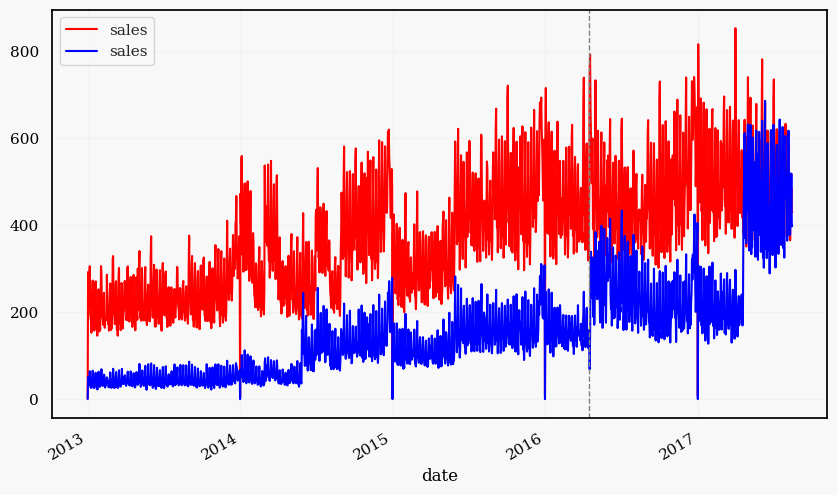

In [74]:
# Cálculo de la media de ventas para el estado de 'Manabí' y el resto de estados
manabi = train.loc[train.state == 'Manabi'].groupby('date')[['sales']].mean()
resto = train.loc[train.state != 'Manabi'].groupby('date')[['sales']].mean()

# Gráfico de líneas con la evolución de las ventas
fig, ax = plt.subplots(figsize=(10, 6))
resto.plot(color='red', label='Resto', ax=ax)
manabi.plot(color='blue', label='Manabi', ax=ax)

# Línea vertical para marcar la fecha del terremoto ('2016-04-16')
ax.axvline(x='2016-04-16', color='gray', linestyle='--', linewidth=1)

Para abordar este problema, crearé una variable que aumente cada día después del terremoto.

In [75]:
fecha_inicial = pd.to_datetime('2016-04-16')
x = pd.Series(train.date.unique())

x = pd.DataFrame((x - fecha_inicial).dt.days + 1).rename(columns = {0:'terremoto'})
x['date'] = pd.Series(train.date.unique())
train = train.merge(x, how = 'left', on = 'date')

train.loc[train.terremoto <= 0, 'terremoto'] = 0
train.tail()

,id,date,store_nbr,family,sales,onpromotion,city,state,tipo_store,cluster,tipo_holiday,locale,locale_name,description,transferred,two_holidays,dcoilwtico,month,day,year,weekday,day_of_year,quarter,season,holiday_navidad,holiday_carnaval,holiday_dia_padre_madre,holiday_cuenca,holiday_viernes_santo,holiday_primer_dia_ano,holiday,onpromotion_disc,cerrada,rotura_stock_20,rotura_stock_31,sales_lag_1_alpha_0.95,sales_lag_7_alpha_0.95,sales_lag_30_alpha_0.95,sales_lag_1_alpha_0.8,sales_lag_7_alpha_0.8,sales_lag_30_alpha_0.8,sales_lag_1_alpha_0.65,sales_lag_7_alpha_0.65,sales_lag_30_alpha_0.65,sales_lag_1_alpha_0.5,sales_lag_7_alpha_0.5,sales_lag_30_alpha_0.5,transactions_rolling_30,sales_acum_rolling_30,wages,terremoto
3000883,3000883,2017-08-15,9,POULTRY,438.13,0,Quito,Pichincha,B,6,Holiday,Local,Riobamba,Fundacion de Riobamba,False,0,47.56,8,15,2017,1,227,3,2,0,0,0,0,0,0,1,0,0,0,0,5.67,5.90,6.34,5.74,5.95,6.32,5.80,6.02,6.29,5.85,6.08,6.24,1821.23,17785.70,1,487
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.55,1,Quito,Pichincha,B,6,Holiday,Local,Riobamba,Fundacion de Riobamba,False,0,47.56,8,15,2017,1,227,3,2,0,0,0,0,0,0,1,0,0,0,0,4.74,4.74,4.85,4.74,4.76,4.86,4.74,4.79,4.86,4.74,4.81,4.84,1821.23,17785.70,1,487
3000885,3000885,2017-08-15,9,PRODUCE,2419.73,148,Quito,Pichincha,B,6,Holiday,Local,Riobamba,Fundacion de Riobamba,False,0,47.56,8,15,2017,1,227,3,2,0,0,0,0,0,0,1,0,0,0,0,7.22,7.73,7.61,7.25,7.69,7.58,7.27,7.65,7.54,7.28,7.61,7.50,1821.23,17785.70,1,487
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.00,8,Quito,Pichincha,B,6,Holiday,Local,Riobamba,Fundacion de Riobamba,False,0,47.56,8,15,2017,1,227,3,2,0,0,0,0,0,0,1,0,0,0,0,5.21,5.14,0.09,5.22,5.12,0.30,5.20,5.12,0.48,5.17,5.11,0.65,1821.23,17785.70,1,487
3000887,3000887,2017-08-15,9,SEAFOOD,16.00,0,Quito,Pichincha,B,6,Holiday,Local,Riobamba,Fundacion de Riobamba,False,0,47.56,8,15,2017,1,227,3,2,0,0,0,0,0,0,1,0,0,0,0,2.90,2.84,3.00,2.92,2.90,3.09,2.94,2.96,3.13,2.95,2.99,3.13,1821.23,17785.70,1,487


### 6.10. Comprobar el dataset

In [76]:
# Eliminar los nulos generados
train = train.dropna()

# Resetear el index
train = train.reset_index(drop = True)

In [77]:
train

,id,date,store_nbr,family,sales,onpromotion,city,state,tipo_store,cluster,tipo_holiday,locale,locale_name,description,transferred,two_holidays,dcoilwtico,month,day,year,weekday,day_of_year,quarter,season,holiday_navidad,holiday_carnaval,holiday_dia_padre_madre,holiday_cuenca,holiday_viernes_santo,holiday_primer_dia_ano,holiday,onpromotion_disc,cerrada,rotura_stock_20,rotura_stock_31,sales_lag_1_alpha_0.95,sales_lag_7_alpha_0.95,sales_lag_30_alpha_0.95,sales_lag_1_alpha_0.8,sales_lag_7_alpha_0.8,sales_lag_30_alpha_0.8,sales_lag_1_alpha_0.65,sales_lag_7_alpha_0.65,sales_lag_30_alpha_0.65,sales_lag_1_alpha_0.5,sales_lag_7_alpha_0.5,sales_lag_30_alpha_0.5,transactions_rolling_30,sales_acum_rolling_30,wages,terremoto
0,53460,2013-01-31,1,AUTOMOTIVE,0.00,0,Quito,Pichincha,D,13,Sin festivo,Sin festivo,Sin festivo,Sin festivo,Sin festivo,0,97.62,1,31,2013,3,31,1,0,0,0,0,0,0,0,0,0,0,0,0,1.92,0.14,0.00,1.83,0.42,0.00,1.74,0.61,0.00,1.65,0.75,0.00,1647.19,5246.61,1,0
1,53461,2013-01-31,1,BABY CARE,0.00,0,Quito,Pichincha,D,13,Sin festivo,Sin festivo,Sin festivo,Sin festivo,Sin festivo,0,97.62,1,31,2013,3,31,1,0,0,0,0,0,0,0,0,0,0,1,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1647.19,5246.61,1,0
2,53462,2013-01-31,1,BEAUTY,2.00,0,Quito,Pichincha,D,13,Sin festivo,Sin festivo,Sin festivo,Sin festivo,Sin festivo,0,97.62,1,31,2013,3,31,1,0,0,0,0,0,0,0,0,0,0,0,0,1.38,0.00,0.00,1.36,0.03,0.00,1.29,0.10,0.00,1.20,0.23,0.00,1647.19,5246.61,1,0
3,53463,2013-01-31,1,BEVERAGES,889.00,0,Quito,Pichincha,D,13,Sin festivo,Sin festivo,Sin festivo,Sin festivo,Sin festivo,0,97.62,1,31,2013,3,31,1,0,0,0,0,0,0,0,0,0,0,0,0,6.93,6.75,0.00,6.91,6.79,0.00,6.88,6.82,0.00,6.84,6.84,0.00,1647.19,5246.61,1,0
4,53464,2013-01-31,1,BOOKS,0.00,0,Quito,Pichincha,D,13,Sin festivo,Sin festivo,Sin festivo,Sin festivo,Sin festivo,0,97.62,1,31,2013,3,31,1,0,0,0,0,0,0,0,0,0,0,1,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1647.19,5246.61,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2947423,3000883,2017-08-15,9,POULTRY,438.13,0,Quito,Pichincha,B,6,Holiday,Local,Riobamba,Fundacion de Riobamba,False,0,47.56,8,15,2017,1,227,3,2,0,0,0,0,0,0,1,0,0,0,0,5.67,5.90,6.34,5.74,5.95,6.32,5.80,6.02,6.29,5.85,6.08,6.24,1821.23,17785.70,1,487
2947424,3000884,2017-08-15,9,PREPARED FOODS,154.55,1,Quito,Pichincha,B,6,Holiday,Local,Riobamba,Fundacion de Riobamba,False,0,47.56,8,15,2017,1,227,3,2,0,0,0,0,0,0,1,0,0,0,0,4.74,4.74,4.85,4.74,4.76,4.86,4.74,4.79,4.86,4.74,4.81,4.84,1821.23,17785.70,1,487
2947425,3000885,2017-08-15,9,PRODUCE,2419.73,148,Quito,Pichincha,B,6,Holiday,Local,Riobamba,Fundacion de Riobamba,False,0,47.56,8,15,2017,1,227,3,2,0,0,0,0,0,0,1,0,0,0,0,7.22,7.73,7.61,7.25,7.69,7.58,7.27,7.65,7.54,7.28,7.61,7.50,1821.23,17785.70,1,487
2947426,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.00,8,Quito,Pichincha,B,6,Holiday,Local,Riobamba,Fundacion de Riobamba,False,0,47.56,8,15,2017,1,227,3,2,0,0,0,0,0,0,1,0,0,0,0,5.21,5.14,0.09,5.22,5.12,0.30,5.20,5.12,0.48,5.17,5.11,0.65,1821.23,17785.70,1,487


---

## 7. Transformación de Datos

### 7.1. Transformación de las variables categóricas

En este caso, todas las variables categóricas son nominales, lo que significa que sus valores no tienen un orden definido. Por lo tanto, utilizaremos *One Hot Encoding* para la transformación de estas variables.

*One Hot Encoding* es una técnica de codificación que convierte variables categóricas en un formato binario, donde cada categoría se representa como una columna y se indica con un valor de 1 si está presente o 0 si no lo está.

In [78]:
var_ohe = ['store_nbr', 'city', 'state', 'tipo_store', 'cluster', 'tipo_holiday', 'locale', 'transferred', 'locale_name']

In [79]:
print('Valores únicos de la variable "locale_name": ', train.locale_name.nunique())
print('Valores únicos de la variable "city": ', train.city.nunique())

Valores únicos de la variable "locale_name":  23
Valores únicos de la variable "city":  22


Estas dos variables tienen muchos valores diferentes, lo que aumentaría excesivamente el tamaño del dataset. Dado que la variable 'locale_name' parece tener menos importancia, optaremos por agrupar sus valores.

In [80]:
train.locale_name.value_counts()

locale_name
Sin festivo                       2503710
Ecuador                            244134
Guayaquil                           17820
Riobamba                            16038
Guaranda                            16038
Quito                               14256
Ambato                              12474
Latacunga                           12474
Cuenca                              10692
Manta                                8910
Esmeraldas                           8910
Cotopaxi                             8910
Cayambe                              8910
Santo Domingo                        8910
Ibarra                               7128
Quevedo                              7128
Santo Domingo de los Tsachilas       7128
Santa Elena                          7128
Libertad                             7128
Loja                                 7128
Salinas                              5346
Puyo                                 5346
Machala                              1782
Name: count, dtype: in

In [81]:
train['locale_name'] = train.locale_name.map({'Sin festivo':'sin_festivo', 'Ecuador':'ecuador'}).fillna('otro')

In [82]:
# Unificar los tipos de los valores de la variable 'transferred'
train['transferred'] = train['transferred'].map({'Sin festivo':'sin_festivo', True:'True', False:'False'})

In [83]:
# Instanciar
ohe = OneHotEncoder(sparse = False, handle_unknown='ignore', drop = 'first')
# Entrenar y aplicar
ohe_train = ohe.fit_transform(train[var_ohe])
ohe_train = pd.DataFrame(ohe_train, columns = ohe.get_feature_names_out())
ohe_train.head()

,store_nbr_2,store_nbr_3,store_nbr_4,store_nbr_5,store_nbr_6,store_nbr_7,store_nbr_8,store_nbr_9,store_nbr_10,store_nbr_11,store_nbr_12,store_nbr_13,store_nbr_14,store_nbr_15,store_nbr_16,store_nbr_17,store_nbr_18,store_nbr_19,store_nbr_20,store_nbr_21,store_nbr_22,store_nbr_23,store_nbr_24,store_nbr_25,store_nbr_26,store_nbr_27,store_nbr_28,store_nbr_29,store_nbr_30,store_nbr_31,store_nbr_32,store_nbr_33,store_nbr_34,store_nbr_35,store_nbr_36,store_nbr_37,store_nbr_38,store_nbr_39,store_nbr_40,store_nbr_41,store_nbr_42,store_nbr_43,store_nbr_44,store_nbr_45,store_nbr_46,store_nbr_47,store_nbr_48,store_nbr_49,store_nbr_50,store_nbr_51,store_nbr_52,store_nbr_53,store_nbr_54,city_Babahoyo,city_Cayambe,city_Cuenca,city_Daule,city_El Carmen,city_Esmeraldas,city_Guaranda,city_Guayaquil,city_Ibarra,city_Latacunga,city_Libertad,city_Loja,city_Machala,city_Manta,city_Playas,city_Puyo,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo,state_Bolivar,state_Chimborazo,state_Cotopaxi,state_El Oro,state_Esmeraldas,state_Guayas,state_Imbabura,state_Loja,state_Los Rios,state_Manabi,state_Pastaza,state_Pichincha,state_Santa Elena,state_Santo Domingo de los Tsachilas,state_Tungurahua,tipo_store_B,tipo_store_C,tipo_store_D,tipo_store_E,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,tipo_holiday_Bridge,tipo_holiday_Event,tipo_holiday_Holiday,tipo_holiday_Sin festivo,tipo_holiday_Transfer,tipo_holiday_Work Day,locale_National,locale_Regional,locale_Sin festivo,transferred_True,transferred_sin_festivo,locale_name_otro,locale_name_sin_festivo
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0

In [84]:
# Eliminar variables originales y unificar el dataset
var_ohe.append('description')
train = train.drop(columns = var_ohe)
train = pd.concat([train, ohe_train], axis = 1)

### 7.2. Reescalado de variables

Para el reescalado de las variables utilizaremos *StandardScaler()*, una técnica que reescala las variables para que tengan una media de 0 y una desviación estándar de 1.

In [85]:
# Guardar las variables que no necesitan reescalado
ids = train[['id', 'date', 'family', 'sales']]
train = train.drop(columns = ['date', 'id', 'family', 'sales'])

In [86]:
# Instanciar
scaler = StandardScaler()
# Entrenar y aplicar
train_scaled = scaler.fit_transform(train)
train_scaled = pd.DataFrame(train_scaled, columns = train.columns.to_list())
train_scaled.head()

,onpromotion,two_holidays,dcoilwtico,month,day,year,weekday,day_of_year,quarter,season,holiday_navidad,holiday_carnaval,holiday_dia_padre_madre,holiday_cuenca,holiday_viernes_santo,holiday_primer_dia_ano,holiday,onpromotion_disc,cerrada,rotura_stock_20,rotura_stock_31,sales_lag_1_alpha_0.95,sales_lag_7_alpha_0.95,sales_lag_30_alpha_0.95,sales_lag_1_alpha_0.8,sales_lag_7_alpha_0.8,sales_lag_30_alpha_0.8,sales_lag_1_alpha_0.65,sales_lag_7_alpha_0.65,sales_lag_30_alpha_0.65,sales_lag_1_alpha_0.5,sales_lag_7_alpha_0.5,sales_lag_30_alpha_0.5,transactions_rolling_30,sales_acum_rolling_30,wages,terremoto,store_nbr_2,store_nbr_3,store_nbr_4,store_nbr_5,store_nbr_6,store_nbr_7,store_nbr_8,store_nbr_9,store_nbr_10,store_nbr_11,store_nbr_12,store_nbr_13,store_nbr_14,store_nbr_15,store_nbr_16,store_nbr_17,store_nbr_18,store_nbr_19,store_nbr_20,store_nbr_21,store_nbr_22,store_nbr_23,store_nbr_24,store_nbr_25,store_nbr_26,store_nbr_27,store_nbr_28,store_nbr_29,store_nbr_30,store_nbr_31,store_nbr_32,store_nbr_33,store_nbr_34,store_nbr_35,store_nbr_36,store_nbr_37,store_nbr_38,store_nbr_39,store_nbr_40,store_nbr_41,store_nbr_42,store_nbr_43,store_nbr_44,store_nbr_45,store_nbr_46,store_nbr_47,store_nbr_48,store_nbr_49,store_nbr_50,store_nbr_51,store_nbr_52,store_nbr_53,store_nbr_54,city_Babahoyo,city_Cayambe,city_Cuenca,city_Daule,city_El Carmen,city_Esmeraldas,city_Guaranda,city_Guayaquil,city_Ibarra,city_Latacunga,city_Libertad,city_Loja,city_Machala,city_Manta,city_Playas,city_Puyo,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo,state_Bolivar,state_Chimborazo,state_Cotopaxi,state_El Oro,state_Esmeraldas,state_Guayas,state_Imbabura,state_Loja,state_Los Rios,state_Manabi,state_Pastaza,state_Pichincha,state_Santa Elena,state_Santo Domingo de los Tsachilas,state_Tungurahua,tipo_store_B,tipo_store_C,tipo_store_D,tipo_store_E,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,tipo_holiday_Bridge,tipo_holiday_Event,tipo_holiday_Holiday,tipo_holiday_Sin festivo,tipo_holiday_Transfer,tipo_holiday_Work Day,locale_National,locale_Regional,locale_Sin festivo,transferred_True,transferred_sin_festivo,locale_name_otro,locale_name_sin_festivo
0,-0.22,-0.12,1.18,-1.59,1.75,-1.40,0.00,-1.42,-1.31,-1.34,-0.10,-0.08,-0.07,-0.06,-0.06,-0.05,-0.42,-0.03,-0.29,-0.55,-0.53,-0.39,-1.05,-1.09,-0.43,-0.95,-1.10,-0.47,-0.89,-1.11,-0.51,-0.85,-1.12,-0.14,-0.74,3.75,-0.53,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.24,-0.14,-0.14,-0.14,-0.14,-0.42,-0.14,-0.20,-0.14,-0.14,-0.20,-0.20,-0.14,-0.14,-0.14,1.41,-0.14,-0.14,-0.24,-0.14,-0.14,-0.20,-0.20,-0.14,-0.51,-0.14,-0.14,-0.20,-0.24,-0.14,1.36,-0.14,-0.24,-0.20,-0.42,-0.62,1.41,-0.28,-0.20,-0.39,-0.24,-0.14,-0.35,-0.20,-0.24,-0.20,-0.35,-0.24,-0.14,3.54,-0.28,-0.32,-0.14,-0.14,-0.03,-0.19,-0.31,0.42,-0.07,-0.04,-0.30,-0.09,0.42,-0.07,0.42,-0.27,0.42
1,-0.22,-0.12,1.18,-1.59,1.75,-1.40,0.00,-1.42,-1.31,-1.34,-0.10,-0.08,-0.07,-0.06,-0.06,-0.05,-0.42,-0.03,-0.29,1.83,-0.53,-1.10,-1.10,-1.09,-1.11,-1.11,-1.10,-1.12,-1.12,-1.11,-1.13,-1.13,-1.12,-0.14,-0.74,3.75,-0.53,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.24,-0.14,-0.14,-0.14,-0.14,-0.42,-0.14,-0.20,-0.14,-0.14,-0.20,-0.20,-0.14,-0.14,-0.14,1.41,-0.14,-0.14,-0.24,-0.14,-0.14,-0.20,-0.20,-0.14,-0.51,-0.14,-0.14,-0.20,-0.24,-0.14,1.36,-0.14,-0.24,-0.20,-0.42,-0.62,1.4

In [87]:
# Unificar el dataset
train = pd.concat([ids, train_scaled], axis = 1)
train.head()

,id,date,family,sales,onpromotion,two_holidays,dcoilwtico,month,day,year,weekday,day_of_year,quarter,season,holiday_navidad,holiday_carnaval,holiday_dia_padre_madre,holiday_cuenca,holiday_viernes_santo,holiday_primer_dia_ano,holiday,onpromotion_disc,cerrada,rotura_stock_20,rotura_stock_31,sales_lag_1_alpha_0.95,sales_lag_7_alpha_0.95,sales_lag_30_alpha_0.95,sales_lag_1_alpha_0.8,sales_lag_7_alpha_0.8,sales_lag_30_alpha_0.8,sales_lag_1_alpha_0.65,sales_lag_7_alpha_0.65,sales_lag_30_alpha_0.65,sales_lag_1_alpha_0.5,sales_lag_7_alpha_0.5,sales_lag_30_alpha_0.5,transactions_rolling_30,sales_acum_rolling_30,wages,terremoto,store_nbr_2,store_nbr_3,store_nbr_4,store_nbr_5,store_nbr_6,store_nbr_7,store_nbr_8,store_nbr_9,store_nbr_10,store_nbr_11,store_nbr_12,store_nbr_13,store_nbr_14,store_nbr_15,store_nbr_16,store_nbr_17,store_nbr_18,store_nbr_19,store_nbr_20,store_nbr_21,store_nbr_22,store_nbr_23,store_nbr_24,store_nbr_25,store_nbr_26,store_nbr_27,store_nbr_28,store_nbr_29,store_nbr_30,store_nbr_31,store_nbr_32,store_nbr_33,store_nbr_34,store_nbr_35,store_nbr_36,store_nbr_37,store_nbr_38,store_nbr_39,store_nbr_40,store_nbr_41,store_nbr_42,store_nbr_43,store_nbr_44,store_nbr_45,store_nbr_46,store_nbr_47,store_nbr_48,store_nbr_49,store_nbr_50,store_nbr_51,store_nbr_52,store_nbr_53,store_nbr_54,city_Babahoyo,city_Cayambe,city_Cuenca,city_Daule,city_El Carmen,city_Esmeraldas,city_Guaranda,city_Guayaquil,city_Ibarra,city_Latacunga,city_Libertad,city_Loja,city_Machala,city_Manta,city_Playas,city_Puyo,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo,state_Bolivar,state_Chimborazo,state_Cotopaxi,state_El Oro,state_Esmeraldas,state_Guayas,state_Imbabura,state_Loja,state_Los Rios,state_Manabi,state_Pastaza,state_Pichincha,state_Santa Elena,state_Santo Domingo de los Tsachilas,state_Tungurahua,tipo_store_B,tipo_store_C,tipo_store_D,tipo_store_E,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,tipo_holiday_Bridge,tipo_holiday_Event,tipo_holiday_Holiday,tipo_holiday_Sin festivo,tipo_holiday_Transfer,tipo_holiday_Work Day,locale_National,locale_Regional,locale_Sin festivo,transferred_True,transferred_sin_festivo,locale_name_otro,locale_name_sin_festivo
0,53460,2013-01-31,AUTOMOTIVE,0.00,-0.22,-0.12,1.18,-1.59,1.75,-1.40,0.00,-1.42,-1.31,-1.34,-0.10,-0.08,-0.07,-0.06,-0.06,-0.05,-0.42,-0.03,-0.29,-0.55,-0.53,-0.39,-1.05,-1.09,-0.43,-0.95,-1.10,-0.47,-0.89,-1.11,-0.51,-0.85,-1.12,-0.14,-0.74,3.75,-0.53,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.24,-0.14,-0.14,-0.14,-0.14,-0.42,-0.14,-0.20,-0.14,-0.14,-0.20,-0.20,-0.14,-0.14,-0.14,1.41,-0.14,-0.14,-0.24,-0.14,-0.14,-0.20,-0.20,-0.14,-0.51,-0.14,-0.14,-0.20,-0.24,-0.14,1.36,-0.14,-0.24,-0.20,-0.42,-0.62,1.41,-0.28,-0.20,-0.39,-0.24,-0.14,-0.35,-0.20,-0.24,-0.20,-0.35,-0.24,-0.14,3.54,-0.28,-0.32,-0.14,-0.14,-0.03,-0.19,-0.31,0.42,-0.07,-0.04,-0.30,-0.09,0.42,-0.07,0.42,-0.27,0.42
1,53461,2013-01-31,BABY CARE,0.00,-0.22,-0.12,1.18,-1.59,1.75,-1.40,0.00,-1.42,-1.31,-1.34,-0.10,-0.08,-0.07,-0.06,-0.06,-0.05,-0.42,-0.03,-0.29,1.83,-0.53,-1.10,-1.10,-1.09,-1.11,-1.11,-1.10,-1.12,-1.12,-1.11,-1.13,-1.13,-1.12,-0.14,-0.74,3.75,-0.53,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.24,-0.14,-0.14,-0.14,-0.14,-0.42,-0.14,-0.20,-0.14,-0.14,-0.20,-0.20,-0.14,-0.14,-0.14,1.41,-0.14,-0.14,-0.24,-0.14,-0.14,-0.20,

### 7.3. Guardar el dataset

In [88]:
# Limpiar los nombres de las columnas
train = clean_names(train)
train.to_csv('../Datos/df_modelizar.csv', index = False)

---

## 8. Preselección de Variables

Para hacer la preselección de variables utilizaremos *Mutual Information*, una medida de la relación estadística entre dos variables, que calcula cuánta información se comparte entre ellas. En el contexto de la regresión, mutual information cuantifica cuánta información de una variable predictora está contenida en la variable de respuesta. 

In [89]:
# Escoger una muestra del dataset
train_pre = train.loc[train.date >= '2017-02-01'].copy()

# Separar entre predictoras y target
x = train_pre.drop(columns = ['id', 'date', 'family', 'sales']).copy()
y = train_pre['sales'].copy()

In [90]:
def ranking_mi(mutual_selector, modo = 'tabla'):
    #Maqueta el ranking
    ranking_mi = pd.DataFrame(mutual_selector, index = x.columns).reset_index()
    ranking_mi.columns = ['variable','importancia_mi']
    ranking_mi = ranking_mi.sort_values(by = 'importancia_mi', ascending = False)
    ranking_mi['ranking_mi'] = np.arange(0,ranking_mi.shape[0])
    #Muestra la salida
    if modo == 'tabla':
        return(ranking_mi)
    else:
        g = ranking_mi.importancia_mi.sort_values().plot.barh(figsize = (12,27))
        g.set_yticklabels(ranking_mi.sort_values(by = 'importancia_mi').variable)
        g.set_title('Importancia de las variables', fontsize=12, fontweight="bold");
        return(g)

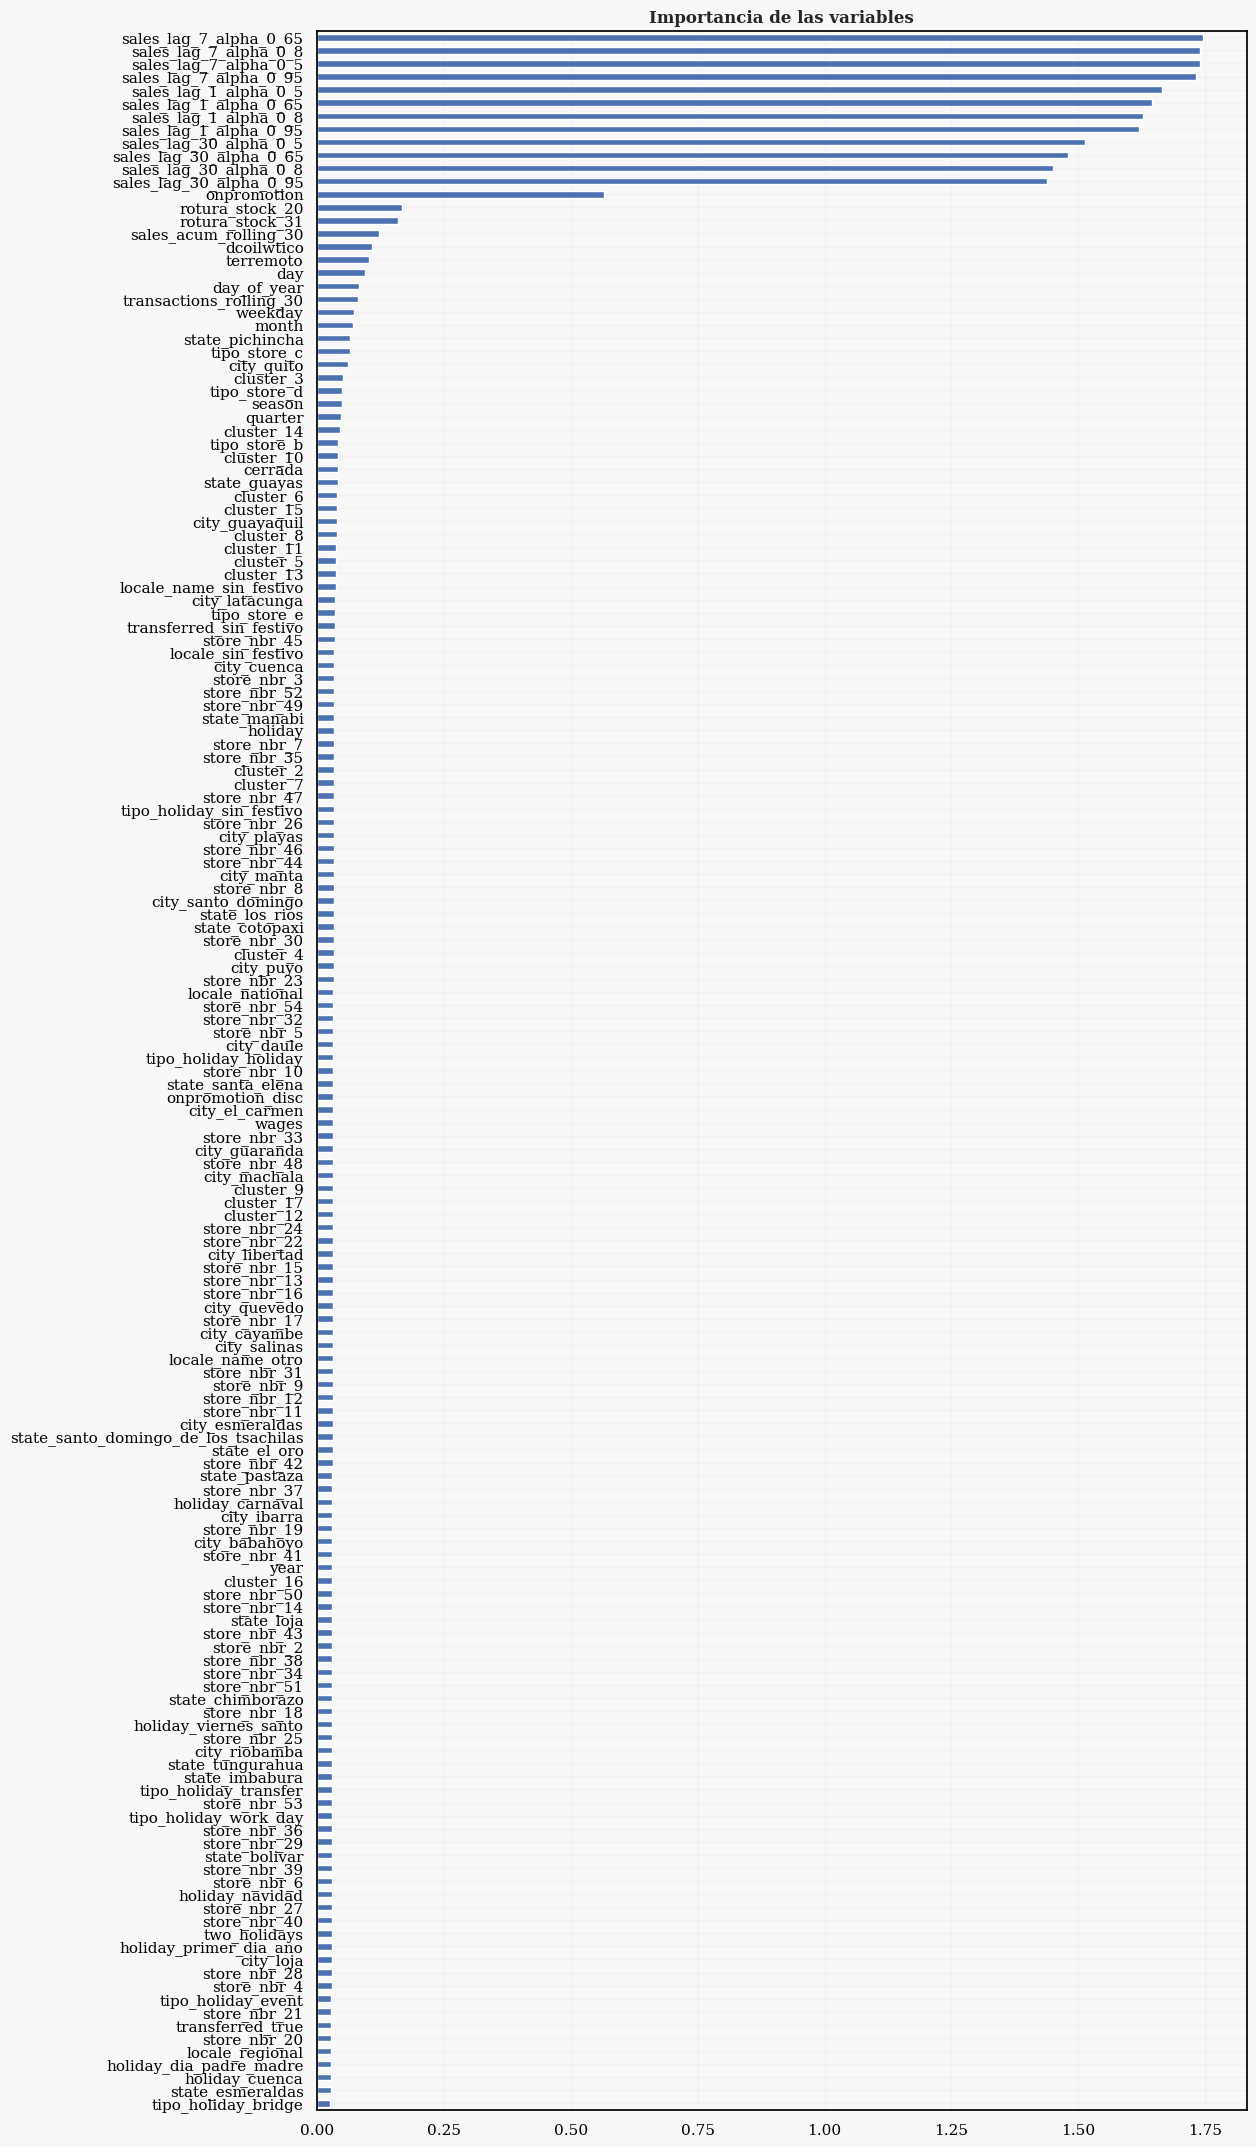

In [91]:
mutual_selector = mutual_info_regression(x,y)

rank_mi = ranking_mi(mutual_selector, modo = 'grafico')

In [92]:
# Seleccionar las variables que entran en el modelo
entran_mi = ranking_mi(mutual_selector).iloc[0:33].variable

# Unirlas con las variables 'ids'
variables_finales = ids.columns.to_list() + entran_mi.to_list()

# Guardar la lista con las variables
with open('../Modelos/variables_finales.pickle', 'wb') as archivo:
    pickle.dump(variables_finales, archivo)